In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Undistort Images using chessBoard

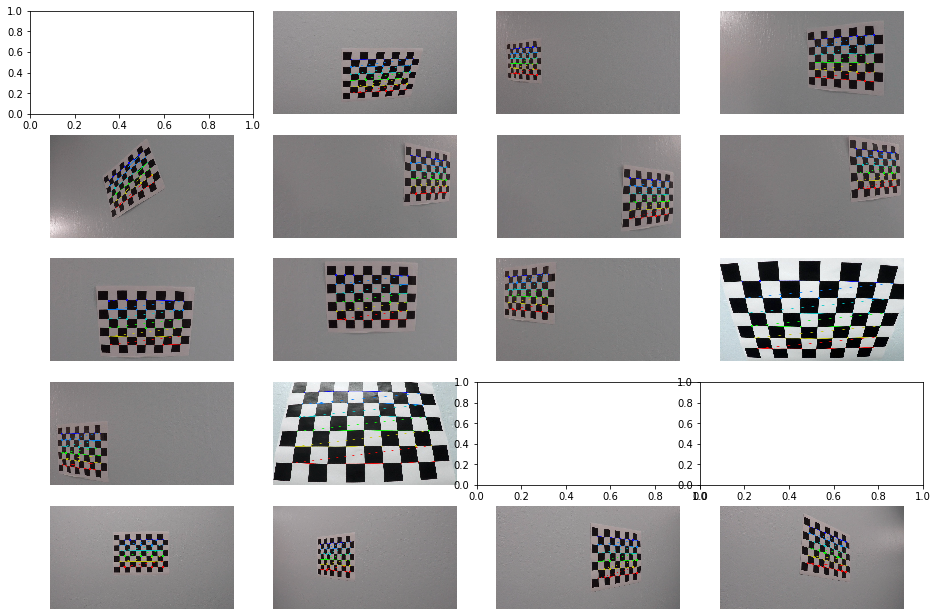

In [3]:
images = glob.glob("camera_cal/calibration*.jpg")
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objpoints = []
imgpoints = []
fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i,fname in enumerate(images):
    img = cv2.imread(fname)
    nx = 9
    ny = 6
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        mg = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        objpoints.append(objp)
        imgpoints.append(corners)
    

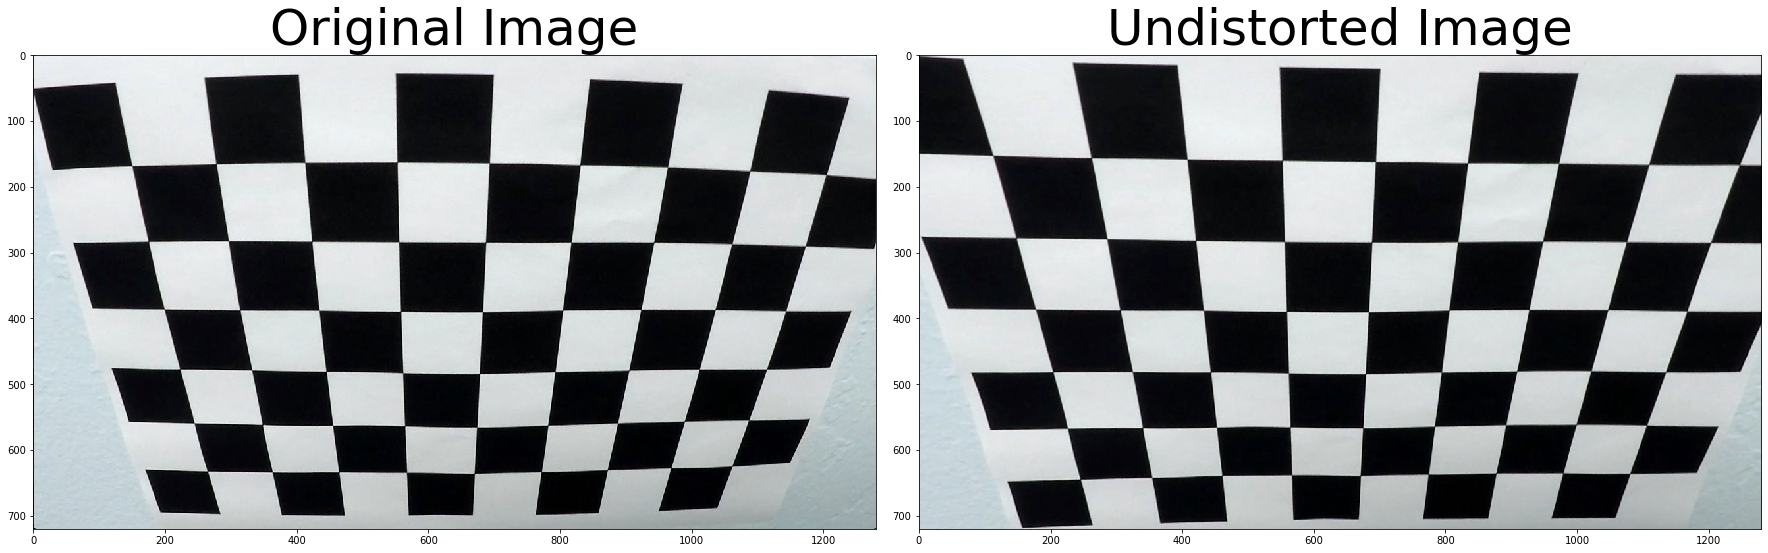

In [4]:
img = cv2.imread("camera_cal/calibration2.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
h,  w = gray.shape[:2]
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

db = {} 
db['mtx'] = mtx 
db['dist'] = dist 
      
pickle.dump( db, open( "calibration.p", "wb" ) )


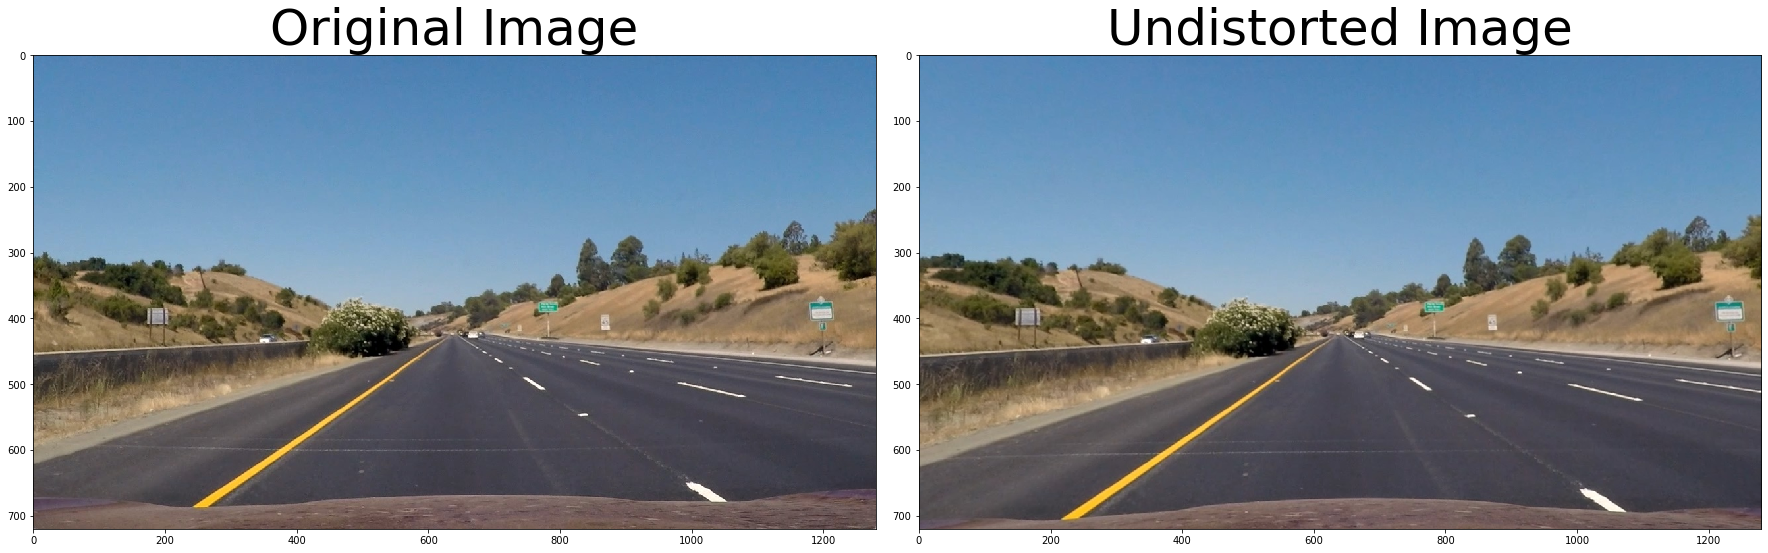

In [5]:
#pickle the matrix and dist for future use
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Undistort and PerspectiveTransform helper functions

In [7]:
def undistort(img):
    dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def undistortAndUnwrap(img):
    undistortImg = undistort(img)
    h,w = img.shape[:2]
    # define source and destination points for transform
    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])
    
    wraped, M, Minv = unwarp(undistortImg, src, dst);
    return wraped, M, Minv

# Visualise the undistorted and unwraped image

Text(0.5, 1.0, 'Unwarped Image')

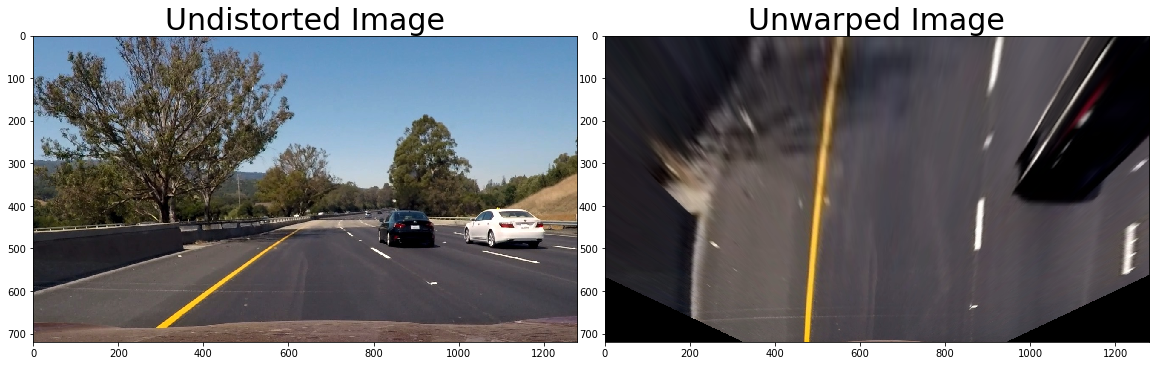

In [28]:

img= cv2.imread("test_images/test6.jpg")
wrap,_,_  = undistortAndUnwrap(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(wrap)
ax2.set_title('Unwarped Image', fontsize=30)

# Different color Spaces and Gradient for image threshold

In [33]:
def abs_sobel_thresh(img, orient, thresh_min, thresh_max):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_lthresh(img, thresh):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,1])
    binary_output[(hls[:,:,1] > thresh[0]) & (hls[:,:,1] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.ones_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 0
    # 3) Return a binary image of threshold result
    return binary_output


# Tuning the threshold values

In [30]:
def update(min_thresh, max_thresh):
    exampleImg_SThresh = hls_lthresh(wrap, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(wrap)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))


interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, description='max_thresh', max=255), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

In [31]:
def update(min_thresh, max_thresh):
    exampleImg_SThresh = abs_sobel_thresh(wrap,'x', min_thresh, max_thresh)
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(wrap)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('Sobel x ', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, description='max_thresh', max=255), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

In [32]:
def update(dir_kernel_size,min_thresh, max_thresh):
    exampleImg_SThresh = dir_threshold(wrap,dir_kernel_size,(min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(wrap)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('LAB S-Channel', fontsize=30)

interact(update,
         dir_kernel_size=(1,31,2), 
                 min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01))

interactive(children=(IntSlider(value=15, description='dir_kernel_size', max=31, min=1, step=2), FloatSlider(value=0.78, description='min_thresh', max=1.5707963267948966, step=0.01), FloatSlider(value=0.78, description='max_thresh', max=1.5707963267948966, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

In [14]:
def update(min_b_thresh, max_b_thresh):
    exampleImg_LBThresh = lab_bthresh(wrap, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(wrap)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=30)

interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))


interactive(children=(IntSlider(value=127, description='min_b_thresh', max=255), IntSlider(value=127, description='max_b_thresh', max=255), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

Text(0.5, 1.0, 'L threshold')

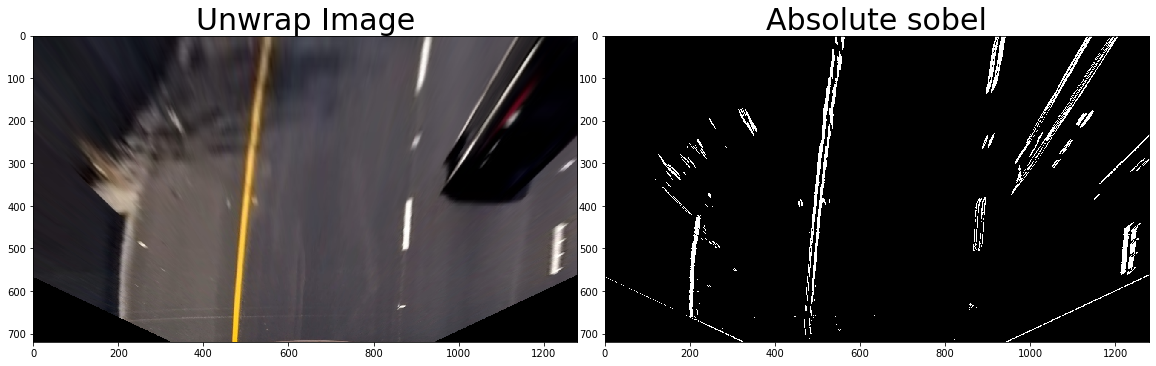

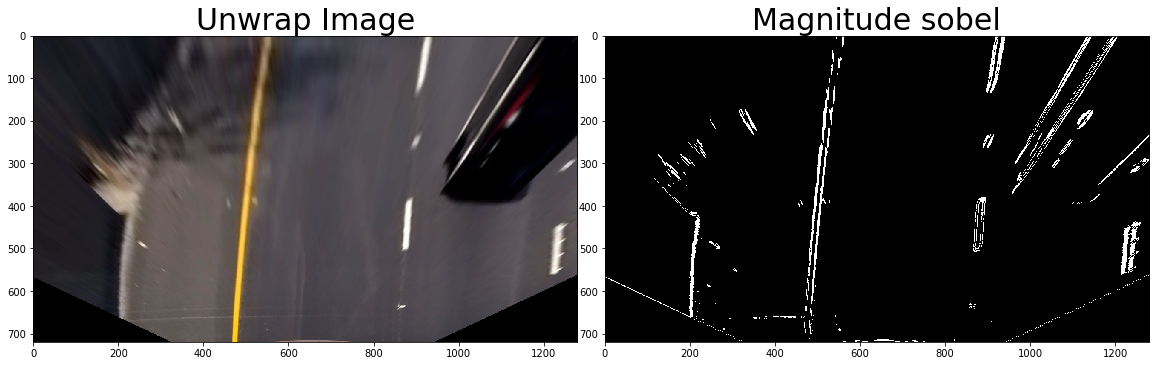

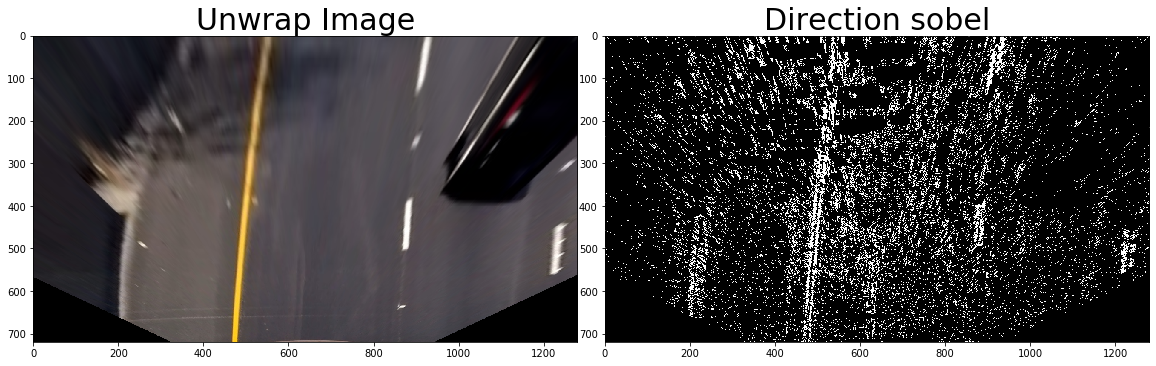

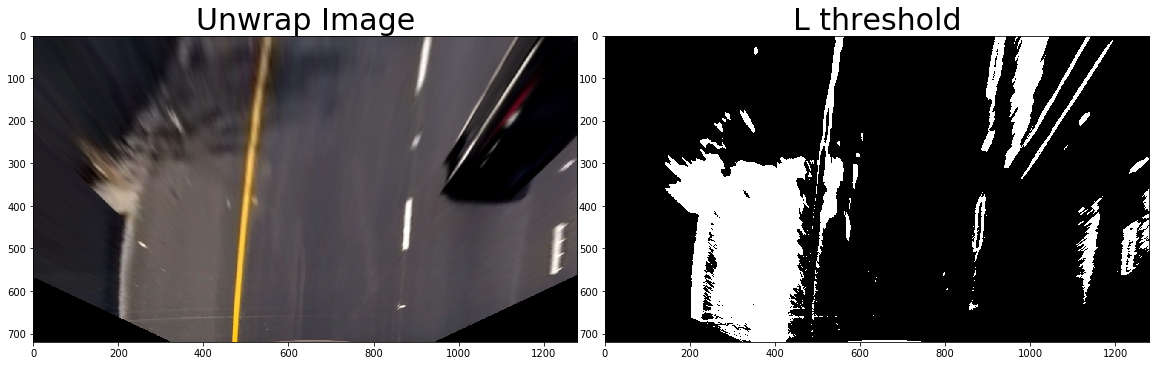

In [15]:
abs_sobel = abs_sobel_thresh(wrap,'x',thresh_min=25, thresh_max=90)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(wrap)
ax1.set_title('Unwrap Image', fontsize=30)
ax2.imshow(abs_sobel,cmap='gray')
ax2.set_title('Absolute sobel', fontsize=30)


mag_sobel = mag_thresh(wrap, 3,(25,70))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(wrap)
ax1.set_title('Unwrap Image', fontsize=30)
ax2.imshow(mag_sobel,cmap='gray')
ax2.set_title('Magnitude sobel', fontsize=30)


dir_sobel = dir_threshold(wrap, 7, (0.04, 0.19))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(wrap)
ax1.set_title('Unwrap Image', fontsize=30)
ax2.imshow(dir_sobel,cmap='gray')
ax2.set_title('Direction sobel', fontsize=30)


hls = hls_sthresh(wrap,(87,125))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(wrap)
ax1.set_title('Unwrap Image', fontsize=30)
ax2.imshow(hls,cmap='gray')
ax2.set_title('L threshold', fontsize=30)

# Combining different gradient and color spaces 

In [16]:
def combinedImg(image):
    wrap,M,MInv  = undistortAndUnwrap(image)
    gradx = abs_sobel_thresh(wrap, 'x',25,70)
    grady = abs_sobel_thresh(wrap, 'y',25,70)
    mag_binary = mag_thresh(wrap, sobel_kernel=3, mag_thresh=(20, 10))
    dir_binary = dir_threshold(wrap, 7, (0.04, 0.19))
    lab = lab_bthresh(wrap,(107,138))
    hls = hls_sthresh(wrap,(220,255))
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) | (grady == 1)) | ((hls == 1)&(dir_binary==1)) | (lab==1)] = 1
    combined[((hls == 1) | (lab==1))] = 1
    
    return combined, MInv

Text(0.5, 1.0, 'Combined')

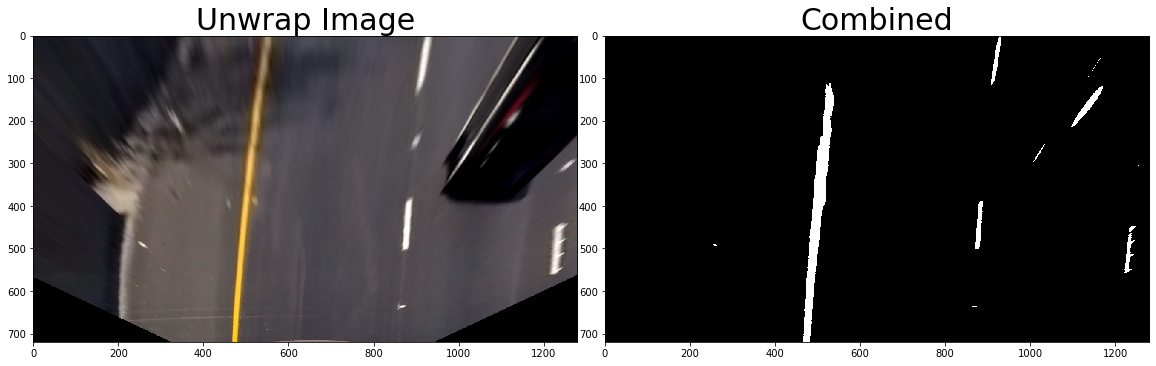

In [35]:
#visualise combined binary image
comb,_ = combinedImg(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(wrap)
ax1.set_title('Unwrap Image', fontsize=30)
ax2.imshow(comb,cmap='gray')
ax2.set_title('Combined', fontsize=30)

# Visualize all test images with binary images

...


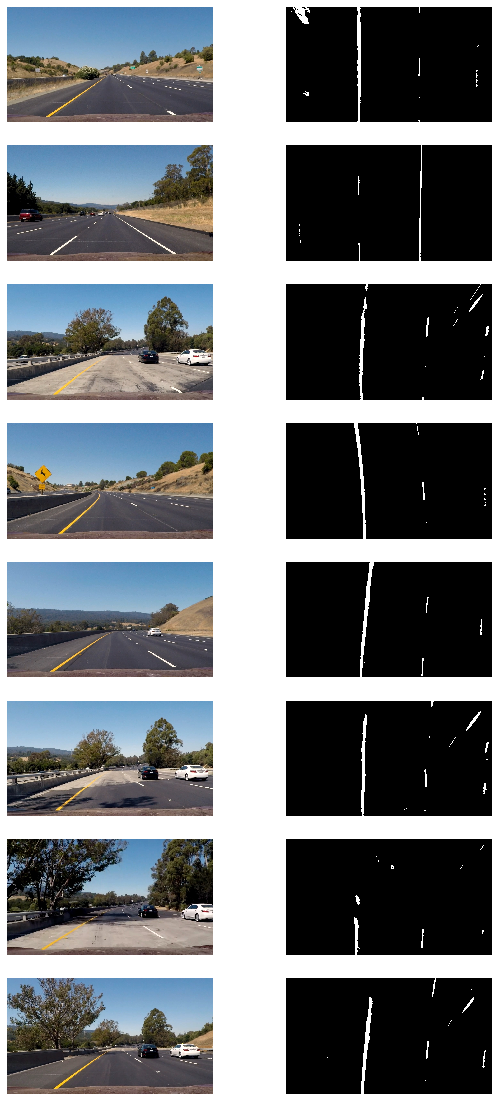

In [18]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img_bin,_= combinedImg(img)
    axs[i].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print('...')

# Finding Lane with histogram and window method

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


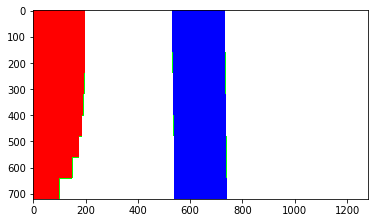

In [19]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit


out_img,_,_ = fit_polynomial(comb)

plt.imshow(out_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


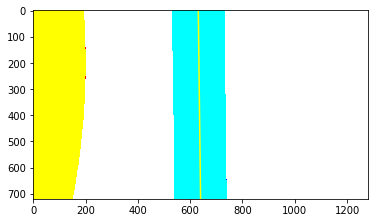

In [20]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
_,left_fit,right_fit = fit_polynomial(comb)
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(comb)

# View your output
plt.imshow(result)

# Measure Curvature of road 

In [21]:
def measure_curvature_real(bin_img,left_fit_cr,right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    car_position = bin_img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*h**2 + left_fit_cr[1]*h + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*h**2 + right_fit_cr[1]*h + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix

    return left_curverad, right_curverad ,center_dist


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad ,center_dist = measure_curvature_real(comb,left_fit,right_fit)

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

2759.4968450262945 m 3.59465411575655e+16 m


# Draw Lanes and also Put text on image

In [22]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(cv2.cvtColor(original_img,cv2.COLOR_BGR2RGB))
    
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h),flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [37]:
def drawText(img, curv_rad, center_dist):
    new_img = np.copy(img)
    
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: '+ '{:04.2f}'.format(curv_rad) + 'm'
    
    cv2.putText(new_img, text, (40,55), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    direction = ''
    if(center_dist < 0):
        direction = 'left'
    else:
        direction = 'right'
    
    abs_center_dist = abs(center_dist)
    
    text = '{:04.3f}'.format(abs_center_dist)+'m ' + direction + ' of center'
    cv2.putText(new_img, text, (40,100), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

# Complete Image processing Pipeline

In [38]:
def processImg(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    img_bin, MInv= combinedImg(img)
    _,left_fit,right_fit = fit_polynomial(img_bin)
    result = draw_lane(img, img_bin, left_fit, right_fit, MInv)
    
    left_curverad, right_curverad ,center_dist = measure_curvature_real(img_bin,left_fit,right_fit)
    curv_rad = (left_curverad + right_curverad)/2
    result = drawText(result,curv_rad,center_dist)
    return result

# Visualize output for all test images

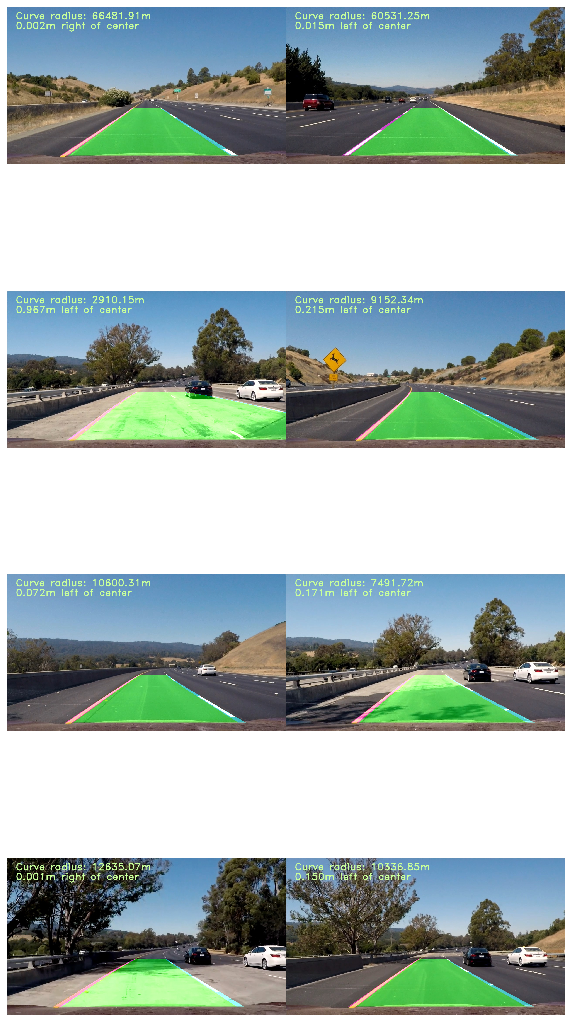

In [46]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    final_img = processImg(img)
    img_bin,_= combinedImg(img)
    cv2.imwrite('./output_images/test{}.jpg'.format(str(i)),img)
    axs[i].axis('off')
    axs[i].imshow(final_img)
    i += 1
    


# Resulting video Processing

In [27]:
output = './output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
output = clip1.fl_image(processImg) #NOTE: this function expects color images!!
%time output.write_videofile(output, audio=False)

t:   0%|                                    | 0/1260 [00:00<?, ?it/s, now=None]

hello
Moviepy - Building video ./output_images/project_video_output.mp4.
Moviepy - Writing video ./output_images/project_video_output.mp4



t:   0%|                            | 2/1260 [00:00<04:55,  4.25it/s, now=None]

hello


t:   0%|                            | 3/1260 [00:00<06:04,  3.44it/s, now=None]

hello


t:   0%|                            | 4/1260 [00:01<07:00,  2.98it/s, now=None]

hello


t:   0%|                            | 5/1260 [00:01<08:17,  2.52it/s, now=None]

hello


t:   0%|▏                           | 6/1260 [00:02<09:04,  2.30it/s, now=None]

hello


t:   1%|▏                           | 7/1260 [00:02<09:33,  2.19it/s, now=None]

hello


t:   1%|▏                           | 8/1260 [00:03<10:01,  2.08it/s, now=None]

hello


t:   1%|▏                           | 9/1260 [00:03<10:11,  2.05it/s, now=None]

hello


t:   1%|▏                          | 10/1260 [00:04<10:35,  1.97it/s, now=None]

hello


t:   1%|▏                          | 11/1260 [00:05<10:45,  1.94it/s, now=None]

hello


t:   1%|▎                          | 12/1260 [00:05<10:48,  1.92it/s, now=None]

hello


t:   1%|▎                          | 13/1260 [00:06<10:34,  1.97it/s, now=None]

hello


t:   1%|▎                          | 14/1260 [00:06<10:40,  1.95it/s, now=None]

hello


t:   1%|▎                          | 15/1260 [00:07<10:41,  1.94it/s, now=None]

hello


t:   1%|▎                          | 16/1260 [00:07<10:45,  1.93it/s, now=None]

hello


t:   1%|▎                          | 17/1260 [00:08<10:40,  1.94it/s, now=None]

hello


t:   1%|▍                          | 18/1260 [00:08<10:27,  1.98it/s, now=None]

hello


t:   2%|▍                          | 19/1260 [00:09<10:12,  2.03it/s, now=None]

hello


t:   2%|▍                          | 20/1260 [00:09<10:01,  2.06it/s, now=None]

hello


t:   2%|▍                          | 21/1260 [00:09<09:27,  2.18it/s, now=None]

hello


t:   2%|▍                          | 22/1260 [00:10<09:05,  2.27it/s, now=None]

hello


t:   2%|▍                          | 23/1260 [00:10<08:39,  2.38it/s, now=None]

hello


t:   2%|▌                          | 24/1260 [00:11<08:18,  2.48it/s, now=None]

hello


t:   2%|▌                          | 25/1260 [00:11<08:14,  2.50it/s, now=None]

hello


t:   2%|▌                          | 26/1260 [00:11<08:31,  2.41it/s, now=None]

hello


t:   2%|▌                          | 27/1260 [00:12<08:16,  2.48it/s, now=None]

hello


t:   2%|▌                          | 28/1260 [00:12<08:06,  2.53it/s, now=None]

hello


t:   2%|▌                          | 29/1260 [00:13<08:01,  2.56it/s, now=None]

hello


t:   2%|▋                          | 30/1260 [00:13<08:39,  2.37it/s, now=None]

hello


t:   2%|▋                          | 31/1260 [00:13<08:36,  2.38it/s, now=None]

hello


t:   3%|▋                          | 32/1260 [00:14<08:36,  2.38it/s, now=None]

hello


t:   3%|▋                          | 33/1260 [00:14<08:46,  2.33it/s, now=None]

hello


t:   3%|▋                          | 34/1260 [00:15<08:24,  2.43it/s, now=None]

hello


t:   3%|▊                          | 35/1260 [00:15<08:04,  2.53it/s, now=None]

hello


t:   3%|▊                          | 36/1260 [00:15<08:14,  2.47it/s, now=None]

hello


t:   3%|▊                          | 37/1260 [00:16<08:10,  2.49it/s, now=None]

hello


t:   3%|▊                          | 38/1260 [00:16<07:50,  2.60it/s, now=None]

hello


t:   3%|▊                          | 39/1260 [00:17<07:38,  2.66it/s, now=None]

hello


t:   3%|▊                          | 40/1260 [00:17<07:32,  2.70it/s, now=None]

hello


t:   3%|▉                          | 41/1260 [00:17<07:27,  2.72it/s, now=None]

hello


t:   3%|▉                          | 42/1260 [00:18<08:03,  2.52it/s, now=None]

hello


t:   3%|▉                          | 43/1260 [00:18<08:05,  2.51it/s, now=None]

hello


t:   3%|▉                          | 44/1260 [00:19<08:16,  2.45it/s, now=None]

hello


t:   4%|▉                          | 45/1260 [00:19<08:08,  2.49it/s, now=None]

hello


t:   4%|▉                          | 46/1260 [00:19<07:59,  2.53it/s, now=None]

hello


t:   4%|█                          | 47/1260 [00:20<07:38,  2.65it/s, now=None]

hello


t:   4%|█                          | 48/1260 [00:20<07:32,  2.68it/s, now=None]

hello


t:   4%|█                          | 49/1260 [00:20<07:29,  2.69it/s, now=None]

hello


t:   4%|█                          | 50/1260 [00:21<08:04,  2.50it/s, now=None]

hello


t:   4%|█                          | 51/1260 [00:21<08:39,  2.33it/s, now=None]

hello


t:   4%|█                          | 52/1260 [00:22<08:08,  2.47it/s, now=None]

hello


t:   4%|█▏                         | 53/1260 [00:22<08:07,  2.48it/s, now=None]

hello


t:   4%|█▏                         | 54/1260 [00:23<08:53,  2.26it/s, now=None]

hello


t:   4%|█▏                         | 55/1260 [00:23<09:05,  2.21it/s, now=None]

hello


t:   4%|█▏                         | 56/1260 [00:24<08:36,  2.33it/s, now=None]

hello


t:   5%|█▏                         | 57/1260 [00:24<08:33,  2.34it/s, now=None]

hello


t:   5%|█▏                         | 58/1260 [00:24<08:27,  2.37it/s, now=None]

hello


t:   5%|█▎                         | 59/1260 [00:25<08:57,  2.24it/s, now=None]

hello


t:   5%|█▎                         | 60/1260 [00:25<09:07,  2.19it/s, now=None]

hello


t:   5%|█▎                         | 61/1260 [00:26<09:08,  2.19it/s, now=None]

hello


t:   5%|█▎                         | 62/1260 [00:26<09:13,  2.17it/s, now=None]

hello


t:   5%|█▎                         | 63/1260 [00:27<09:21,  2.13it/s, now=None]

hello


t:   5%|█▎                         | 64/1260 [00:27<09:21,  2.13it/s, now=None]

hello


t:   5%|█▍                         | 65/1260 [00:28<09:26,  2.11it/s, now=None]

hello


t:   5%|█▍                         | 66/1260 [00:28<09:33,  2.08it/s, now=None]

hello


t:   5%|█▍                         | 67/1260 [00:29<09:48,  2.03it/s, now=None]

hello


t:   5%|█▍                         | 68/1260 [00:29<09:46,  2.03it/s, now=None]

hello


t:   5%|█▍                         | 69/1260 [00:30<09:41,  2.05it/s, now=None]

hello


t:   6%|█▌                         | 70/1260 [00:30<09:34,  2.07it/s, now=None]

hello


t:   6%|█▌                         | 71/1260 [00:31<09:27,  2.10it/s, now=None]

hello


t:   6%|█▌                         | 72/1260 [00:31<09:26,  2.10it/s, now=None]

hello


t:   6%|█▌                         | 73/1260 [00:32<09:27,  2.09it/s, now=None]

hello


t:   6%|█▌                         | 74/1260 [00:32<09:23,  2.10it/s, now=None]

hello


t:   6%|█▌                         | 75/1260 [00:33<09:22,  2.11it/s, now=None]

hello


t:   6%|█▋                         | 76/1260 [00:33<09:21,  2.11it/s, now=None]

hello


t:   6%|█▋                         | 77/1260 [00:33<09:18,  2.12it/s, now=None]

hello


t:   6%|█▋                         | 78/1260 [00:34<09:07,  2.16it/s, now=None]

hello


t:   6%|█▋                         | 79/1260 [00:34<09:03,  2.17it/s, now=None]

hello


t:   6%|█▋                         | 80/1260 [00:35<09:04,  2.17it/s, now=None]

hello


t:   6%|█▋                         | 81/1260 [00:35<09:07,  2.15it/s, now=None]

hello


t:   7%|█▊                         | 82/1260 [00:36<09:04,  2.16it/s, now=None]

hello


t:   7%|█▊                         | 83/1260 [00:36<09:03,  2.17it/s, now=None]

hello


t:   7%|█▊                         | 84/1260 [00:37<09:07,  2.15it/s, now=None]

hello


t:   7%|█▊                         | 85/1260 [00:37<09:10,  2.13it/s, now=None]

hello


t:   7%|█▊                         | 86/1260 [00:38<08:54,  2.20it/s, now=None]

hello


t:   7%|█▊                         | 87/1260 [00:38<08:27,  2.31it/s, now=None]

hello


t:   7%|█▉                         | 88/1260 [00:38<08:08,  2.40it/s, now=None]

hello


t:   7%|█▉                         | 89/1260 [00:39<07:44,  2.52it/s, now=None]

hello


t:   7%|█▉                         | 90/1260 [00:39<07:24,  2.63it/s, now=None]

hello


t:   7%|█▉                         | 91/1260 [00:39<07:06,  2.74it/s, now=None]

hello


t:   7%|█▉                         | 92/1260 [00:40<07:03,  2.76it/s, now=None]

hello


t:   7%|█▉                         | 93/1260 [00:40<06:57,  2.80it/s, now=None]

hello


t:   7%|██                         | 94/1260 [00:41<07:37,  2.55it/s, now=None]

hello


t:   8%|██                         | 95/1260 [00:41<07:59,  2.43it/s, now=None]

hello


t:   8%|██                         | 96/1260 [00:41<08:22,  2.31it/s, now=None]

hello


t:   8%|██                         | 97/1260 [00:42<08:41,  2.23it/s, now=None]

hello


t:   8%|██                         | 98/1260 [00:42<09:03,  2.14it/s, now=None]

hello


t:   8%|██                         | 99/1260 [00:43<09:13,  2.10it/s, now=None]

hello


t:   8%|██                        | 100/1260 [00:44<09:27,  2.04it/s, now=None]

hello


t:   8%|██                        | 101/1260 [00:44<09:26,  2.05it/s, now=None]

hello


t:   8%|██                        | 102/1260 [00:44<09:28,  2.04it/s, now=None]

hello


t:   8%|██▏                       | 103/1260 [00:45<09:23,  2.05it/s, now=None]

hello


t:   8%|██▏                       | 104/1260 [00:45<09:26,  2.04it/s, now=None]

hello


t:   8%|██▏                       | 105/1260 [00:46<09:17,  2.07it/s, now=None]

hello


t:   8%|██▏                       | 106/1260 [00:46<09:28,  2.03it/s, now=None]

hello


t:   8%|██▏                       | 107/1260 [00:47<09:35,  2.00it/s, now=None]

hello


t:   9%|██▏                       | 108/1260 [00:47<09:23,  2.04it/s, now=None]

hello


t:   9%|██▏                       | 109/1260 [00:48<09:28,  2.03it/s, now=None]

hello


t:   9%|██▎                       | 110/1260 [00:48<09:54,  1.93it/s, now=None]

hello


t:   9%|██▎                       | 111/1260 [00:49<09:52,  1.94it/s, now=None]

hello


t:   9%|██▎                       | 112/1260 [00:50<09:54,  1.93it/s, now=None]

hello


t:   9%|██▎                       | 113/1260 [00:50<09:51,  1.94it/s, now=None]

hello


t:   9%|██▎                       | 114/1260 [00:51<10:00,  1.91it/s, now=None]

hello


t:   9%|██▎                       | 115/1260 [00:51<09:56,  1.92it/s, now=None]

hello


t:   9%|██▍                       | 116/1260 [00:52<10:04,  1.89it/s, now=None]

hello


t:   9%|██▍                       | 117/1260 [00:52<10:07,  1.88it/s, now=None]

hello


t:   9%|██▍                       | 118/1260 [00:53<10:10,  1.87it/s, now=None]

hello


t:   9%|██▍                       | 119/1260 [00:53<10:03,  1.89it/s, now=None]

hello


t:  10%|██▍                       | 120/1260 [00:54<10:05,  1.88it/s, now=None]

hello


t:  10%|██▍                       | 121/1260 [00:54<10:08,  1.87it/s, now=None]

hello


t:  10%|██▌                       | 122/1260 [00:55<10:09,  1.87it/s, now=None]

hello


t:  10%|██▌                       | 123/1260 [00:55<09:59,  1.90it/s, now=None]

hello


t:  10%|██▌                       | 124/1260 [00:56<09:53,  1.91it/s, now=None]

hello


t:  10%|██▌                       | 125/1260 [00:56<10:01,  1.89it/s, now=None]

hello


t:  10%|██▌                       | 126/1260 [00:57<09:54,  1.91it/s, now=None]

hello


t:  10%|██▌                       | 127/1260 [00:57<09:18,  2.03it/s, now=None]

hello


t:  10%|██▋                       | 128/1260 [00:58<08:56,  2.11it/s, now=None]

hello


t:  10%|██▋                       | 129/1260 [00:58<09:00,  2.09it/s, now=None]

hello


t:  10%|██▋                       | 130/1260 [00:59<08:59,  2.10it/s, now=None]

hello


t:  10%|██▋                       | 131/1260 [00:59<08:28,  2.22it/s, now=None]

hello


t:  10%|██▋                       | 132/1260 [01:00<08:32,  2.20it/s, now=None]

hello


t:  11%|██▋                       | 133/1260 [01:00<08:32,  2.20it/s, now=None]

hello


t:  11%|██▊                       | 134/1260 [01:00<08:18,  2.26it/s, now=None]

hello


t:  11%|██▊                       | 135/1260 [01:01<08:52,  2.11it/s, now=None]

hello


t:  11%|██▊                       | 136/1260 [01:02<08:55,  2.10it/s, now=None]

hello


t:  11%|██▊                       | 137/1260 [01:02<08:51,  2.11it/s, now=None]

hello


t:  11%|██▊                       | 138/1260 [01:02<08:41,  2.15it/s, now=None]

hello


t:  11%|██▊                       | 139/1260 [01:03<08:31,  2.19it/s, now=None]

hello


t:  11%|██▉                       | 140/1260 [01:03<08:32,  2.19it/s, now=None]

hello


t:  11%|██▉                       | 141/1260 [01:04<08:14,  2.26it/s, now=None]

hello


t:  11%|██▉                       | 142/1260 [01:04<08:34,  2.17it/s, now=None]

hello


t:  11%|██▉                       | 143/1260 [01:05<08:50,  2.10it/s, now=None]

hello


t:  11%|██▉                       | 144/1260 [01:05<09:06,  2.04it/s, now=None]

hello


t:  12%|██▉                       | 145/1260 [01:06<08:58,  2.07it/s, now=None]

hello


t:  12%|███                       | 146/1260 [01:06<09:02,  2.05it/s, now=None]

hello


t:  12%|███                       | 147/1260 [01:07<08:56,  2.07it/s, now=None]

hello


t:  12%|███                       | 148/1260 [01:07<08:47,  2.11it/s, now=None]

hello


t:  12%|███                       | 149/1260 [01:08<08:50,  2.10it/s, now=None]

hello


t:  12%|███                       | 150/1260 [01:08<09:07,  2.03it/s, now=None]

hello


t:  12%|███                       | 151/1260 [01:09<08:26,  2.19it/s, now=None]

hello


t:  12%|███▏                      | 152/1260 [01:09<08:17,  2.23it/s, now=None]

hello


t:  12%|███▏                      | 153/1260 [01:09<08:37,  2.14it/s, now=None]

hello


t:  12%|███▏                      | 154/1260 [01:10<08:33,  2.15it/s, now=None]

hello


t:  12%|███▏                      | 155/1260 [01:10<08:18,  2.22it/s, now=None]

hello


t:  12%|███▏                      | 156/1260 [01:11<08:12,  2.24it/s, now=None]

hello


t:  12%|███▏                      | 157/1260 [01:11<08:04,  2.28it/s, now=None]

hello


t:  13%|███▎                      | 158/1260 [01:12<08:22,  2.20it/s, now=None]

hello


t:  13%|███▎                      | 159/1260 [01:12<08:33,  2.15it/s, now=None]

hello


t:  13%|███▎                      | 160/1260 [01:13<08:21,  2.20it/s, now=None]

hello


t:  13%|███▎                      | 161/1260 [01:13<08:13,  2.23it/s, now=None]

hello


t:  13%|███▎                      | 162/1260 [01:14<08:17,  2.21it/s, now=None]

hello


t:  13%|███▎                      | 163/1260 [01:14<08:12,  2.23it/s, now=None]

hello


t:  13%|███▍                      | 164/1260 [01:14<08:28,  2.16it/s, now=None]

hello


t:  13%|███▍                      | 165/1260 [01:15<08:20,  2.19it/s, now=None]

hello


t:  13%|███▍                      | 166/1260 [01:15<08:21,  2.18it/s, now=None]

hello


t:  13%|███▍                      | 167/1260 [01:16<08:19,  2.19it/s, now=None]

hello


t:  13%|███▍                      | 168/1260 [01:16<08:16,  2.20it/s, now=None]

hello


t:  13%|███▍                      | 169/1260 [01:17<08:18,  2.19it/s, now=None]

hello


t:  13%|███▌                      | 170/1260 [01:17<08:27,  2.15it/s, now=None]

hello


t:  14%|███▌                      | 171/1260 [01:18<08:36,  2.11it/s, now=None]

hello


t:  14%|███▌                      | 172/1260 [01:18<08:37,  2.10it/s, now=None]

hello


t:  14%|███▌                      | 173/1260 [01:19<08:44,  2.07it/s, now=None]

hello


t:  14%|███▌                      | 174/1260 [01:19<08:44,  2.07it/s, now=None]

hello


t:  14%|███▌                      | 175/1260 [01:20<08:27,  2.14it/s, now=None]

hello


t:  14%|███▋                      | 176/1260 [01:20<08:04,  2.24it/s, now=None]

hello


t:  14%|███▋                      | 177/1260 [01:20<07:42,  2.34it/s, now=None]

hello


t:  14%|███▋                      | 178/1260 [01:21<07:28,  2.41it/s, now=None]

hello


t:  14%|███▋                      | 179/1260 [01:21<07:13,  2.50it/s, now=None]

hello


t:  14%|███▋                      | 180/1260 [01:22<07:06,  2.53it/s, now=None]

hello


t:  14%|███▋                      | 181/1260 [01:22<06:57,  2.59it/s, now=None]

hello


t:  14%|███▊                      | 182/1260 [01:22<06:57,  2.58it/s, now=None]

hello


t:  15%|███▊                      | 183/1260 [01:23<06:56,  2.59it/s, now=None]

hello


t:  15%|███▊                      | 184/1260 [01:23<06:51,  2.61it/s, now=None]

hello


t:  15%|███▊                      | 185/1260 [01:23<07:06,  2.52it/s, now=None]

hello


t:  15%|███▊                      | 186/1260 [01:24<07:32,  2.37it/s, now=None]

hello


t:  15%|███▊                      | 187/1260 [01:24<07:46,  2.30it/s, now=None]

hello


t:  15%|███▉                      | 188/1260 [01:25<07:53,  2.27it/s, now=None]

hello


t:  15%|███▉                      | 189/1260 [01:25<08:01,  2.22it/s, now=None]

hello


t:  15%|███▉                      | 190/1260 [01:26<08:05,  2.20it/s, now=None]

hello


t:  15%|███▉                      | 191/1260 [01:26<08:07,  2.19it/s, now=None]

hello


t:  15%|███▉                      | 192/1260 [01:27<08:06,  2.20it/s, now=None]

hello


t:  15%|███▉                      | 193/1260 [01:27<08:01,  2.22it/s, now=None]

hello


t:  15%|████                      | 194/1260 [01:28<08:10,  2.17it/s, now=None]

hello


t:  15%|████                      | 195/1260 [01:28<08:10,  2.17it/s, now=None]

hello


t:  16%|████                      | 196/1260 [01:29<08:10,  2.17it/s, now=None]

hello


t:  16%|████                      | 197/1260 [01:29<08:08,  2.18it/s, now=None]

hello


t:  16%|████                      | 198/1260 [01:29<08:13,  2.15it/s, now=None]

hello


t:  16%|████                      | 199/1260 [01:30<08:10,  2.16it/s, now=None]

hello


t:  16%|████▏                     | 200/1260 [01:30<08:10,  2.16it/s, now=None]

hello


t:  16%|████▏                     | 201/1260 [01:31<08:08,  2.17it/s, now=None]

hello


t:  16%|████▏                     | 202/1260 [01:31<08:13,  2.14it/s, now=None]

hello


t:  16%|████▏                     | 203/1260 [01:32<08:13,  2.14it/s, now=None]

hello


t:  16%|████▏                     | 204/1260 [01:32<08:10,  2.15it/s, now=None]

hello


t:  16%|████▏                     | 205/1260 [01:33<08:11,  2.15it/s, now=None]

hello


t:  16%|████▎                     | 206/1260 [01:33<08:10,  2.15it/s, now=None]

hello


t:  16%|████▎                     | 207/1260 [01:34<08:07,  2.16it/s, now=None]

hello


t:  17%|████▎                     | 208/1260 [01:34<08:03,  2.18it/s, now=None]

hello


t:  17%|████▎                     | 209/1260 [01:35<07:51,  2.23it/s, now=None]

hello


t:  17%|████▎                     | 210/1260 [01:35<07:50,  2.23it/s, now=None]

hello


t:  17%|████▎                     | 211/1260 [01:35<07:41,  2.27it/s, now=None]

hello


t:  17%|████▎                     | 212/1260 [01:36<07:24,  2.36it/s, now=None]

hello


t:  17%|████▍                     | 213/1260 [01:36<07:11,  2.43it/s, now=None]

hello


t:  17%|████▍                     | 214/1260 [01:37<07:05,  2.46it/s, now=None]

hello


t:  17%|████▍                     | 215/1260 [01:37<06:56,  2.51it/s, now=None]

hello


t:  17%|████▍                     | 216/1260 [01:37<06:58,  2.50it/s, now=None]

hello


t:  17%|████▍                     | 217/1260 [01:38<06:57,  2.50it/s, now=None]

hello


t:  17%|████▍                     | 218/1260 [01:38<06:57,  2.49it/s, now=None]

hello


t:  17%|████▌                     | 219/1260 [01:39<06:48,  2.55it/s, now=None]

hello


t:  17%|████▌                     | 220/1260 [01:39<06:45,  2.57it/s, now=None]

hello


t:  18%|████▌                     | 221/1260 [01:39<06:40,  2.59it/s, now=None]

hello


t:  18%|████▌                     | 222/1260 [01:40<06:40,  2.59it/s, now=None]

hello


t:  18%|████▌                     | 223/1260 [01:40<06:43,  2.57it/s, now=None]

hello


t:  18%|████▌                     | 224/1260 [01:40<06:38,  2.60it/s, now=None]

hello


t:  18%|████▋                     | 225/1260 [01:41<06:34,  2.63it/s, now=None]

hello


t:  18%|████▋                     | 226/1260 [01:41<06:45,  2.55it/s, now=None]

hello


t:  18%|████▋                     | 227/1260 [01:42<06:35,  2.61it/s, now=None]

hello


t:  18%|████▋                     | 228/1260 [01:42<06:38,  2.59it/s, now=None]

hello


t:  18%|████▋                     | 229/1260 [01:42<06:34,  2.62it/s, now=None]

hello


t:  18%|████▋                     | 230/1260 [01:43<06:38,  2.59it/s, now=None]

hello


t:  18%|████▊                     | 231/1260 [01:43<06:33,  2.61it/s, now=None]

hello


t:  18%|████▊                     | 232/1260 [01:44<06:39,  2.57it/s, now=None]

hello


t:  18%|████▊                     | 233/1260 [01:44<06:42,  2.55it/s, now=None]

hello


t:  19%|████▊                     | 234/1260 [01:44<06:46,  2.53it/s, now=None]

hello


t:  19%|████▊                     | 235/1260 [01:45<06:42,  2.54it/s, now=None]

hello


t:  19%|████▊                     | 236/1260 [01:45<06:47,  2.52it/s, now=None]

hello


t:  19%|████▉                     | 237/1260 [01:45<06:34,  2.59it/s, now=None]

hello


t:  19%|████▉                     | 238/1260 [01:46<06:49,  2.50it/s, now=None]

hello


t:  19%|████▉                     | 239/1260 [01:46<06:39,  2.56it/s, now=None]

hello


t:  19%|████▉                     | 240/1260 [01:47<07:10,  2.37it/s, now=None]

hello


t:  19%|████▉                     | 241/1260 [01:47<07:11,  2.36it/s, now=None]

hello


t:  19%|████▉                     | 242/1260 [01:48<06:55,  2.45it/s, now=None]

hello


t:  19%|█████                     | 243/1260 [01:48<06:34,  2.58it/s, now=None]

hello


t:  19%|█████                     | 244/1260 [01:48<06:24,  2.64it/s, now=None]

hello


t:  19%|█████                     | 245/1260 [01:49<06:07,  2.76it/s, now=None]

hello


t:  20%|█████                     | 246/1260 [01:49<06:50,  2.47it/s, now=None]

hello


t:  20%|█████                     | 247/1260 [01:50<06:47,  2.49it/s, now=None]

hello


t:  20%|█████                     | 248/1260 [01:50<07:43,  2.18it/s, now=None]

hello


t:  20%|█████▏                    | 249/1260 [01:51<07:37,  2.21it/s, now=None]

hello


t:  20%|█████▏                    | 250/1260 [01:51<07:36,  2.21it/s, now=None]

hello


t:  20%|█████▏                    | 251/1260 [01:51<07:07,  2.36it/s, now=None]

hello


t:  20%|█████▏                    | 252/1260 [01:52<07:29,  2.24it/s, now=None]

hello


t:  20%|█████▏                    | 253/1260 [01:52<07:00,  2.39it/s, now=None]

hello


t:  20%|█████▏                    | 254/1260 [01:53<06:41,  2.51it/s, now=None]

hello


t:  20%|█████▎                    | 255/1260 [01:53<06:22,  2.63it/s, now=None]

hello


t:  20%|█████▎                    | 256/1260 [01:53<06:09,  2.72it/s, now=None]

hello


t:  20%|█████▎                    | 257/1260 [01:54<06:01,  2.77it/s, now=None]

hello


t:  20%|█████▎                    | 258/1260 [01:54<06:06,  2.73it/s, now=None]

hello


t:  21%|█████▎                    | 259/1260 [01:54<06:22,  2.62it/s, now=None]

hello


t:  21%|█████▎                    | 260/1260 [01:55<06:21,  2.62it/s, now=None]

hello


t:  21%|█████▍                    | 261/1260 [01:55<06:05,  2.74it/s, now=None]

hello


t:  21%|█████▍                    | 262/1260 [01:55<05:58,  2.78it/s, now=None]

hello


t:  21%|█████▍                    | 263/1260 [01:56<06:00,  2.77it/s, now=None]

hello


t:  21%|█████▍                    | 264/1260 [01:56<06:22,  2.60it/s, now=None]

hello


t:  21%|█████▍                    | 265/1260 [01:57<07:21,  2.26it/s, now=None]

hello


t:  21%|█████▍                    | 266/1260 [01:57<07:24,  2.24it/s, now=None]

hello


t:  21%|█████▌                    | 267/1260 [01:58<07:25,  2.23it/s, now=None]

hello


t:  21%|█████▌                    | 268/1260 [01:58<06:51,  2.41it/s, now=None]

hello


t:  21%|█████▌                    | 269/1260 [01:58<06:33,  2.52it/s, now=None]

hello


t:  21%|█████▌                    | 270/1260 [01:59<06:25,  2.57it/s, now=None]

hello


t:  22%|█████▌                    | 271/1260 [01:59<06:14,  2.64it/s, now=None]

hello


t:  22%|█████▌                    | 272/1260 [01:59<06:01,  2.73it/s, now=None]

hello


t:  22%|█████▋                    | 273/1260 [02:00<06:03,  2.72it/s, now=None]

hello


t:  22%|█████▋                    | 274/1260 [02:00<06:17,  2.61it/s, now=None]

hello


t:  22%|█████▋                    | 275/1260 [02:01<06:06,  2.69it/s, now=None]

hello


t:  22%|█████▋                    | 276/1260 [02:01<05:57,  2.75it/s, now=None]

hello


t:  22%|█████▋                    | 277/1260 [02:01<05:52,  2.79it/s, now=None]

hello


t:  22%|█████▋                    | 278/1260 [02:02<06:08,  2.66it/s, now=None]

hello


t:  22%|█████▊                    | 279/1260 [02:02<06:48,  2.40it/s, now=None]

hello


t:  22%|█████▊                    | 280/1260 [02:03<06:32,  2.50it/s, now=None]

hello


t:  22%|█████▊                    | 281/1260 [02:03<06:11,  2.63it/s, now=None]

hello


t:  22%|█████▊                    | 282/1260 [02:03<06:09,  2.65it/s, now=None]

hello


t:  22%|█████▊                    | 283/1260 [02:04<06:03,  2.69it/s, now=None]

hello


t:  23%|█████▊                    | 284/1260 [02:04<05:55,  2.75it/s, now=None]

hello


t:  23%|█████▉                    | 285/1260 [02:04<05:53,  2.76it/s, now=None]

hello


t:  23%|█████▉                    | 286/1260 [02:05<05:51,  2.77it/s, now=None]

hello


t:  23%|█████▉                    | 287/1260 [02:05<06:09,  2.63it/s, now=None]

hello


t:  23%|█████▉                    | 288/1260 [02:06<06:18,  2.57it/s, now=None]

hello


t:  23%|█████▉                    | 289/1260 [02:06<06:12,  2.61it/s, now=None]

hello


t:  23%|█████▉                    | 290/1260 [02:06<06:05,  2.66it/s, now=None]

hello


t:  23%|██████                    | 291/1260 [02:07<05:58,  2.70it/s, now=None]

hello


t:  23%|██████                    | 292/1260 [02:07<05:54,  2.73it/s, now=None]

hello


t:  23%|██████                    | 293/1260 [02:07<05:57,  2.71it/s, now=None]

hello


t:  23%|██████                    | 294/1260 [02:08<06:07,  2.63it/s, now=None]

hello


t:  23%|██████                    | 295/1260 [02:08<06:04,  2.64it/s, now=None]

hello


t:  23%|██████                    | 296/1260 [02:09<06:01,  2.66it/s, now=None]

hello


t:  24%|██████▏                   | 297/1260 [02:09<05:56,  2.70it/s, now=None]

hello


t:  24%|██████▏                   | 298/1260 [02:09<05:54,  2.71it/s, now=None]

hello


t:  24%|██████▏                   | 299/1260 [02:10<05:51,  2.74it/s, now=None]

hello


t:  24%|██████▏                   | 300/1260 [02:10<05:46,  2.77it/s, now=None]

hello


t:  24%|██████▏                   | 301/1260 [02:10<05:38,  2.83it/s, now=None]

hello


t:  24%|██████▏                   | 302/1260 [02:11<05:34,  2.86it/s, now=None]

hello


t:  24%|██████▎                   | 303/1260 [02:11<05:40,  2.81it/s, now=None]

hello


t:  24%|██████▎                   | 304/1260 [02:11<05:32,  2.88it/s, now=None]

hello


t:  24%|██████▎                   | 305/1260 [02:12<05:27,  2.91it/s, now=None]

hello


t:  24%|██████▎                   | 306/1260 [02:12<05:29,  2.89it/s, now=None]

hello


t:  24%|██████▎                   | 307/1260 [02:12<05:29,  2.90it/s, now=None]

hello


t:  24%|██████▎                   | 308/1260 [02:13<05:56,  2.67it/s, now=None]

hello


t:  25%|██████▍                   | 309/1260 [02:13<06:02,  2.62it/s, now=None]

hello


t:  25%|██████▍                   | 310/1260 [02:14<05:55,  2.67it/s, now=None]

hello


t:  25%|██████▍                   | 311/1260 [02:14<05:53,  2.68it/s, now=None]

hello


t:  25%|██████▍                   | 312/1260 [02:14<05:45,  2.74it/s, now=None]

hello


t:  25%|██████▍                   | 313/1260 [02:15<06:07,  2.57it/s, now=None]

hello


t:  25%|██████▍                   | 314/1260 [02:15<05:57,  2.65it/s, now=None]

hello


t:  25%|██████▌                   | 315/1260 [02:15<05:56,  2.65it/s, now=None]

hello


t:  25%|██████▌                   | 316/1260 [02:16<05:54,  2.66it/s, now=None]

hello


t:  25%|██████▌                   | 317/1260 [02:16<05:46,  2.72it/s, now=None]

hello


t:  25%|██████▌                   | 318/1260 [02:17<05:42,  2.75it/s, now=None]

hello


t:  25%|██████▌                   | 319/1260 [02:17<05:41,  2.76it/s, now=None]

hello


t:  25%|██████▌                   | 320/1260 [02:17<05:30,  2.84it/s, now=None]

hello


t:  25%|██████▌                   | 321/1260 [02:18<05:26,  2.87it/s, now=None]

hello


t:  26%|██████▋                   | 322/1260 [02:18<05:21,  2.92it/s, now=None]

hello


t:  26%|██████▋                   | 323/1260 [02:18<05:22,  2.91it/s, now=None]

hello


t:  26%|██████▋                   | 324/1260 [02:19<05:22,  2.90it/s, now=None]

hello


t:  26%|██████▋                   | 325/1260 [02:19<05:27,  2.86it/s, now=None]

hello


t:  26%|██████▋                   | 326/1260 [02:19<05:34,  2.79it/s, now=None]

hello


t:  26%|██████▋                   | 327/1260 [02:20<05:44,  2.71it/s, now=None]

hello


t:  26%|██████▊                   | 328/1260 [02:20<06:12,  2.50it/s, now=None]

hello


t:  26%|██████▊                   | 329/1260 [02:21<06:01,  2.58it/s, now=None]

hello


t:  26%|██████▊                   | 330/1260 [02:21<05:54,  2.62it/s, now=None]

hello


t:  26%|██████▊                   | 331/1260 [02:21<05:50,  2.65it/s, now=None]

hello


t:  26%|██████▊                   | 332/1260 [02:22<05:40,  2.73it/s, now=None]

hello


t:  26%|██████▊                   | 333/1260 [02:22<05:32,  2.79it/s, now=None]

hello


t:  27%|██████▉                   | 334/1260 [02:22<05:30,  2.80it/s, now=None]

hello


t:  27%|██████▉                   | 335/1260 [02:23<05:30,  2.80it/s, now=None]

hello


t:  27%|██████▉                   | 336/1260 [02:23<05:25,  2.84it/s, now=None]

hello


t:  27%|██████▉                   | 337/1260 [02:23<05:37,  2.73it/s, now=None]

hello


t:  27%|██████▉                   | 338/1260 [02:24<05:31,  2.78it/s, now=None]

hello


t:  27%|██████▉                   | 339/1260 [02:24<06:02,  2.54it/s, now=None]

hello


t:  27%|███████                   | 340/1260 [02:25<06:17,  2.43it/s, now=None]

hello


t:  27%|███████                   | 341/1260 [02:25<06:12,  2.47it/s, now=None]

hello


t:  27%|███████                   | 342/1260 [02:25<06:08,  2.49it/s, now=None]

hello


t:  27%|███████                   | 343/1260 [02:26<06:11,  2.47it/s, now=None]

hello


t:  27%|███████                   | 344/1260 [02:26<06:09,  2.48it/s, now=None]

hello


t:  27%|███████                   | 345/1260 [02:27<06:05,  2.51it/s, now=None]

hello


t:  27%|███████▏                  | 346/1260 [02:27<06:03,  2.52it/s, now=None]

hello


t:  28%|███████▏                  | 347/1260 [02:27<06:05,  2.50it/s, now=None]

hello


t:  28%|███████▏                  | 348/1260 [02:28<06:04,  2.50it/s, now=None]

hello


t:  28%|███████▏                  | 349/1260 [02:28<05:58,  2.54it/s, now=None]

hello


t:  28%|███████▏                  | 350/1260 [02:29<05:51,  2.59it/s, now=None]

hello


t:  28%|███████▏                  | 351/1260 [02:29<06:00,  2.52it/s, now=None]

hello


t:  28%|███████▎                  | 352/1260 [02:29<05:56,  2.55it/s, now=None]

hello


t:  28%|███████▎                  | 353/1260 [02:30<05:51,  2.58it/s, now=None]

hello


t:  28%|███████▎                  | 354/1260 [02:30<05:55,  2.55it/s, now=None]

hello


t:  28%|███████▎                  | 355/1260 [02:31<05:52,  2.57it/s, now=None]

hello


t:  28%|███████▎                  | 356/1260 [02:31<05:53,  2.56it/s, now=None]

hello


t:  28%|███████▎                  | 357/1260 [02:31<05:51,  2.57it/s, now=None]

hello


t:  28%|███████▍                  | 358/1260 [02:32<06:09,  2.44it/s, now=None]

hello


t:  28%|███████▍                  | 359/1260 [02:32<06:26,  2.33it/s, now=None]

hello


t:  29%|███████▍                  | 360/1260 [02:33<06:31,  2.30it/s, now=None]

hello


t:  29%|███████▍                  | 361/1260 [02:33<06:18,  2.37it/s, now=None]

hello


t:  29%|███████▍                  | 362/1260 [02:34<06:31,  2.29it/s, now=None]

hello


t:  29%|███████▍                  | 363/1260 [02:34<06:50,  2.18it/s, now=None]

hello


t:  29%|███████▌                  | 364/1260 [02:35<06:51,  2.18it/s, now=None]

hello


t:  29%|███████▌                  | 365/1260 [02:35<06:41,  2.23it/s, now=None]

hello


t:  29%|███████▌                  | 366/1260 [02:35<06:42,  2.22it/s, now=None]

hello


t:  29%|███████▌                  | 367/1260 [02:36<07:03,  2.11it/s, now=None]

hello


t:  29%|███████▌                  | 368/1260 [02:36<07:11,  2.07it/s, now=None]

hello


t:  29%|███████▌                  | 369/1260 [02:37<07:06,  2.09it/s, now=None]

hello


t:  29%|███████▋                  | 370/1260 [02:37<06:44,  2.20it/s, now=None]

hello


t:  29%|███████▋                  | 371/1260 [02:38<06:30,  2.28it/s, now=None]

hello


t:  30%|███████▋                  | 372/1260 [02:38<06:31,  2.27it/s, now=None]

hello


t:  30%|███████▋                  | 373/1260 [02:39<06:33,  2.26it/s, now=None]

hello


t:  30%|███████▋                  | 374/1260 [02:39<06:34,  2.25it/s, now=None]

hello


t:  30%|███████▋                  | 375/1260 [02:40<06:35,  2.24it/s, now=None]

hello


t:  30%|███████▊                  | 376/1260 [02:40<06:47,  2.17it/s, now=None]

hello


t:  30%|███████▊                  | 377/1260 [02:40<06:41,  2.20it/s, now=None]

hello


t:  30%|███████▊                  | 378/1260 [02:41<06:48,  2.16it/s, now=None]

hello


t:  30%|███████▊                  | 379/1260 [02:41<06:54,  2.13it/s, now=None]

hello


t:  30%|███████▊                  | 380/1260 [02:42<06:56,  2.11it/s, now=None]

hello


t:  30%|███████▊                  | 381/1260 [02:42<07:22,  1.99it/s, now=None]

hello


t:  30%|███████▉                  | 382/1260 [02:43<06:45,  2.16it/s, now=None]

hello


t:  30%|███████▉                  | 383/1260 [02:44<07:36,  1.92it/s, now=None]

hello


t:  30%|███████▉                  | 384/1260 [02:44<07:38,  1.91it/s, now=None]

hello


t:  31%|███████▉                  | 385/1260 [02:44<07:19,  1.99it/s, now=None]

hello


t:  31%|███████▉                  | 386/1260 [02:45<09:08,  1.59it/s, now=None]

hello


t:  31%|███████▉                  | 387/1260 [02:46<09:23,  1.55it/s, now=None]

hello


t:  31%|████████                  | 388/1260 [02:47<09:06,  1.60it/s, now=None]

hello


t:  31%|████████                  | 389/1260 [02:47<08:59,  1.62it/s, now=None]

hello


t:  31%|████████                  | 390/1260 [02:48<08:42,  1.67it/s, now=None]

hello


t:  31%|████████                  | 391/1260 [02:49<09:05,  1.59it/s, now=None]

hello


t:  31%|████████                  | 392/1260 [02:49<08:48,  1.64it/s, now=None]

hello


t:  31%|████████                  | 393/1260 [02:50<08:13,  1.76it/s, now=None]

hello


t:  31%|████████▏                 | 394/1260 [02:50<07:59,  1.81it/s, now=None]

hello


t:  31%|████████▏                 | 395/1260 [02:51<08:04,  1.78it/s, now=None]

hello


t:  31%|████████▏                 | 396/1260 [02:51<07:53,  1.82it/s, now=None]

hello


t:  32%|████████▏                 | 397/1260 [02:52<07:52,  1.83it/s, now=None]

hello


t:  32%|████████▏                 | 398/1260 [02:52<07:36,  1.89it/s, now=None]

hello


t:  32%|████████▏                 | 399/1260 [02:53<07:25,  1.93it/s, now=None]

hello


t:  32%|████████▎                 | 400/1260 [02:53<07:07,  2.01it/s, now=None]

hello


t:  32%|████████▎                 | 401/1260 [02:54<06:48,  2.10it/s, now=None]

hello


t:  32%|████████▎                 | 402/1260 [02:54<06:40,  2.14it/s, now=None]

hello


t:  32%|████████▎                 | 403/1260 [02:54<06:41,  2.14it/s, now=None]

hello


t:  32%|████████▎                 | 404/1260 [02:55<06:18,  2.26it/s, now=None]

hello


t:  32%|████████▎                 | 405/1260 [02:55<06:01,  2.36it/s, now=None]

hello


t:  32%|████████▍                 | 406/1260 [02:56<05:53,  2.42it/s, now=None]

hello


t:  32%|████████▍                 | 407/1260 [02:56<05:59,  2.37it/s, now=None]

hello


t:  32%|████████▍                 | 408/1260 [02:56<05:49,  2.44it/s, now=None]

hello


t:  32%|████████▍                 | 409/1260 [02:57<05:45,  2.46it/s, now=None]

hello


t:  33%|████████▍                 | 410/1260 [02:57<05:52,  2.41it/s, now=None]

hello


t:  33%|████████▍                 | 411/1260 [02:58<05:45,  2.46it/s, now=None]

hello


t:  33%|████████▌                 | 412/1260 [02:58<05:34,  2.54it/s, now=None]

hello


t:  33%|████████▌                 | 413/1260 [02:59<06:02,  2.34it/s, now=None]

hello


t:  33%|████████▌                 | 414/1260 [02:59<06:22,  2.21it/s, now=None]

hello


t:  33%|████████▌                 | 415/1260 [03:00<06:35,  2.14it/s, now=None]

hello


t:  33%|████████▌                 | 416/1260 [03:00<07:09,  1.96it/s, now=None]

hello


t:  33%|████████▌                 | 417/1260 [03:01<07:00,  2.01it/s, now=None]

hello


t:  33%|████████▋                 | 418/1260 [03:01<06:54,  2.03it/s, now=None]

hello


t:  33%|████████▋                 | 419/1260 [03:02<06:56,  2.02it/s, now=None]

hello


t:  33%|████████▋                 | 420/1260 [03:02<06:28,  2.16it/s, now=None]

hello


t:  33%|████████▋                 | 421/1260 [03:02<06:15,  2.23it/s, now=None]

hello


t:  33%|████████▋                 | 422/1260 [03:03<05:56,  2.35it/s, now=None]

hello


t:  34%|████████▋                 | 423/1260 [03:03<05:53,  2.37it/s, now=None]

hello


t:  34%|████████▋                 | 424/1260 [03:04<05:43,  2.43it/s, now=None]

hello


t:  34%|████████▊                 | 425/1260 [03:04<05:41,  2.45it/s, now=None]

hello


t:  34%|████████▊                 | 426/1260 [03:04<05:31,  2.51it/s, now=None]

hello


t:  34%|████████▊                 | 427/1260 [03:05<05:25,  2.56it/s, now=None]

hello


t:  34%|████████▊                 | 428/1260 [03:05<05:17,  2.62it/s, now=None]

hello


t:  34%|████████▊                 | 429/1260 [03:05<05:14,  2.64it/s, now=None]

hello


t:  34%|████████▊                 | 430/1260 [03:06<05:11,  2.67it/s, now=None]

hello


t:  34%|████████▉                 | 431/1260 [03:06<05:11,  2.66it/s, now=None]

hello


t:  34%|████████▉                 | 432/1260 [03:07<05:10,  2.67it/s, now=None]

hello


t:  34%|████████▉                 | 433/1260 [03:07<05:07,  2.69it/s, now=None]

hello


t:  34%|████████▉                 | 434/1260 [03:07<05:03,  2.72it/s, now=None]

hello


t:  35%|████████▉                 | 435/1260 [03:08<05:16,  2.61it/s, now=None]

hello


t:  35%|████████▉                 | 436/1260 [03:08<05:16,  2.60it/s, now=None]

hello


t:  35%|█████████                 | 437/1260 [03:09<05:14,  2.62it/s, now=None]

hello


t:  35%|█████████                 | 438/1260 [03:09<05:06,  2.68it/s, now=None]

hello


t:  35%|█████████                 | 439/1260 [03:09<05:16,  2.59it/s, now=None]

hello


t:  35%|█████████                 | 440/1260 [03:10<05:14,  2.61it/s, now=None]

hello


t:  35%|█████████                 | 441/1260 [03:10<05:09,  2.65it/s, now=None]

hello


t:  35%|█████████                 | 442/1260 [03:10<05:06,  2.67it/s, now=None]

hello


t:  35%|█████████▏                | 443/1260 [03:11<05:11,  2.62it/s, now=None]

hello


t:  35%|█████████▏                | 444/1260 [03:11<05:12,  2.61it/s, now=None]

hello


t:  35%|█████████▏                | 445/1260 [03:12<05:03,  2.69it/s, now=None]

hello


t:  35%|█████████▏                | 446/1260 [03:12<05:02,  2.69it/s, now=None]

hello


t:  35%|█████████▏                | 447/1260 [03:12<05:10,  2.62it/s, now=None]

hello


t:  36%|█████████▏                | 448/1260 [03:13<05:04,  2.66it/s, now=None]

hello


t:  36%|█████████▎                | 449/1260 [03:13<05:01,  2.69it/s, now=None]

hello


t:  36%|█████████▎                | 450/1260 [03:13<05:02,  2.68it/s, now=None]

hello


t:  36%|█████████▎                | 451/1260 [03:14<05:06,  2.64it/s, now=None]

hello


t:  36%|█████████▎                | 452/1260 [03:14<05:03,  2.66it/s, now=None]

hello


t:  36%|█████████▎                | 453/1260 [03:15<04:58,  2.71it/s, now=None]

hello


t:  36%|█████████▎                | 454/1260 [03:15<04:54,  2.73it/s, now=None]

hello


t:  36%|█████████▍                | 455/1260 [03:15<05:04,  2.64it/s, now=None]

hello


t:  36%|█████████▍                | 456/1260 [03:16<05:01,  2.66it/s, now=None]

hello


t:  36%|█████████▍                | 457/1260 [03:16<05:03,  2.65it/s, now=None]

hello


t:  36%|█████████▍                | 458/1260 [03:16<05:02,  2.65it/s, now=None]

hello


t:  36%|█████████▍                | 459/1260 [03:17<05:04,  2.63it/s, now=None]

hello


t:  37%|█████████▍                | 460/1260 [03:17<05:01,  2.65it/s, now=None]

hello


t:  37%|█████████▌                | 461/1260 [03:18<04:59,  2.67it/s, now=None]

hello


t:  37%|█████████▌                | 462/1260 [03:18<05:04,  2.62it/s, now=None]

hello


t:  37%|█████████▌                | 463/1260 [03:18<05:07,  2.59it/s, now=None]

hello


t:  37%|█████████▌                | 464/1260 [03:19<05:05,  2.60it/s, now=None]

hello


t:  37%|█████████▌                | 465/1260 [03:19<05:04,  2.61it/s, now=None]

hello


t:  37%|█████████▌                | 466/1260 [03:19<05:02,  2.62it/s, now=None]

hello


t:  37%|█████████▋                | 467/1260 [03:20<05:13,  2.53it/s, now=None]

hello


t:  37%|█████████▋                | 468/1260 [03:20<05:50,  2.26it/s, now=None]

hello


t:  37%|█████████▋                | 469/1260 [03:21<05:42,  2.31it/s, now=None]

hello


t:  37%|█████████▋                | 470/1260 [03:21<05:55,  2.22it/s, now=None]

hello


t:  37%|█████████▋                | 471/1260 [03:22<05:41,  2.31it/s, now=None]

hello


t:  37%|█████████▋                | 472/1260 [03:22<05:25,  2.42it/s, now=None]

hello


t:  38%|█████████▊                | 473/1260 [03:22<05:09,  2.55it/s, now=None]

hello


t:  38%|█████████▊                | 474/1260 [03:23<05:00,  2.61it/s, now=None]

hello


t:  38%|█████████▊                | 475/1260 [03:23<05:02,  2.59it/s, now=None]

hello


t:  38%|█████████▊                | 476/1260 [03:24<05:00,  2.61it/s, now=None]

hello


t:  38%|█████████▊                | 477/1260 [03:24<04:53,  2.66it/s, now=None]

hello


t:  38%|█████████▊                | 478/1260 [03:24<04:51,  2.68it/s, now=None]

hello


t:  38%|█████████▉                | 479/1260 [03:25<04:51,  2.68it/s, now=None]

hello


t:  38%|█████████▉                | 480/1260 [03:25<04:51,  2.67it/s, now=None]

hello


t:  38%|█████████▉                | 481/1260 [03:25<04:49,  2.69it/s, now=None]

hello


t:  38%|█████████▉                | 482/1260 [03:26<04:47,  2.71it/s, now=None]

hello


t:  38%|█████████▉                | 483/1260 [03:26<04:50,  2.68it/s, now=None]

hello


t:  38%|█████████▉                | 484/1260 [03:27<04:49,  2.68it/s, now=None]

hello


t:  38%|██████████                | 485/1260 [03:27<04:48,  2.69it/s, now=None]

hello


t:  39%|██████████                | 486/1260 [03:27<04:44,  2.72it/s, now=None]

hello


t:  39%|██████████                | 487/1260 [03:28<04:47,  2.68it/s, now=None]

hello


t:  39%|██████████                | 488/1260 [03:28<04:45,  2.71it/s, now=None]

hello


t:  39%|██████████                | 489/1260 [03:28<04:43,  2.72it/s, now=None]

hello


t:  39%|██████████                | 490/1260 [03:29<04:41,  2.74it/s, now=None]

hello


t:  39%|██████████▏               | 491/1260 [03:29<04:48,  2.67it/s, now=None]

hello


t:  39%|██████████▏               | 492/1260 [03:30<04:48,  2.66it/s, now=None]

hello


t:  39%|██████████▏               | 493/1260 [03:30<04:48,  2.65it/s, now=None]

hello


t:  39%|██████████▏               | 494/1260 [03:30<04:48,  2.66it/s, now=None]

hello


t:  39%|██████████▏               | 495/1260 [03:31<04:51,  2.63it/s, now=None]

hello


t:  39%|██████████▏               | 496/1260 [03:31<04:46,  2.67it/s, now=None]

hello


t:  39%|██████████▎               | 497/1260 [03:31<04:43,  2.69it/s, now=None]

hello


t:  40%|██████████▎               | 498/1260 [03:32<04:38,  2.74it/s, now=None]

hello


t:  40%|██████████▎               | 499/1260 [03:32<04:41,  2.71it/s, now=None]

hello


t:  40%|██████████▎               | 500/1260 [03:32<04:41,  2.70it/s, now=None]

hello


t:  40%|██████████▎               | 501/1260 [03:33<04:33,  2.77it/s, now=None]

hello


t:  40%|██████████▎               | 502/1260 [03:33<04:30,  2.80it/s, now=None]

hello


t:  40%|██████████▍               | 503/1260 [03:34<04:32,  2.78it/s, now=None]

hello


t:  40%|██████████▍               | 504/1260 [03:34<04:31,  2.78it/s, now=None]

hello


t:  40%|██████████▍               | 505/1260 [03:34<04:28,  2.81it/s, now=None]

hello


t:  40%|██████████▍               | 506/1260 [03:35<04:27,  2.82it/s, now=None]

hello


t:  40%|██████████▍               | 507/1260 [03:35<04:33,  2.75it/s, now=None]

hello


t:  40%|██████████▍               | 508/1260 [03:35<04:32,  2.76it/s, now=None]

hello


t:  40%|██████████▌               | 509/1260 [03:36<04:30,  2.78it/s, now=None]

hello


t:  40%|██████████▌               | 510/1260 [03:36<04:30,  2.78it/s, now=None]

hello


t:  41%|██████████▌               | 511/1260 [03:36<04:29,  2.78it/s, now=None]

hello


t:  41%|██████████▌               | 512/1260 [03:37<04:31,  2.76it/s, now=None]

hello


t:  41%|██████████▌               | 513/1260 [03:37<04:30,  2.76it/s, now=None]

hello


t:  41%|██████████▌               | 514/1260 [03:37<04:26,  2.79it/s, now=None]

hello


t:  41%|██████████▋               | 515/1260 [03:38<04:32,  2.73it/s, now=None]

hello


t:  41%|██████████▋               | 516/1260 [03:38<04:31,  2.74it/s, now=None]

hello


t:  41%|██████████▋               | 517/1260 [03:39<04:34,  2.70it/s, now=None]

hello


t:  41%|██████████▋               | 518/1260 [03:39<04:35,  2.70it/s, now=None]

hello


t:  41%|██████████▋               | 519/1260 [03:39<04:37,  2.67it/s, now=None]

hello


t:  41%|██████████▋               | 520/1260 [03:40<04:36,  2.67it/s, now=None]

hello


t:  41%|██████████▊               | 521/1260 [03:40<04:44,  2.60it/s, now=None]

hello


t:  41%|██████████▊               | 522/1260 [03:40<04:34,  2.69it/s, now=None]

hello


t:  42%|██████████▊               | 523/1260 [03:41<04:39,  2.63it/s, now=None]

hello


t:  42%|██████████▊               | 524/1260 [03:41<04:40,  2.62it/s, now=None]

hello


t:  42%|██████████▊               | 525/1260 [03:42<04:31,  2.71it/s, now=None]

hello


t:  42%|██████████▊               | 526/1260 [03:42<04:29,  2.72it/s, now=None]

hello


t:  42%|██████████▊               | 527/1260 [03:42<04:42,  2.60it/s, now=None]

hello


t:  42%|██████████▉               | 528/1260 [03:43<04:34,  2.67it/s, now=None]

hello


t:  42%|██████████▉               | 529/1260 [03:43<04:24,  2.76it/s, now=None]

hello


t:  42%|██████████▉               | 530/1260 [03:43<04:16,  2.85it/s, now=None]

hello


t:  42%|██████████▉               | 531/1260 [03:44<04:14,  2.87it/s, now=None]

hello


t:  42%|██████████▉               | 532/1260 [03:44<04:14,  2.86it/s, now=None]

hello


t:  42%|██████████▉               | 533/1260 [03:44<04:09,  2.91it/s, now=None]

hello


t:  42%|███████████               | 534/1260 [03:45<04:07,  2.94it/s, now=None]

hello


t:  42%|███████████               | 535/1260 [03:45<04:05,  2.95it/s, now=None]

hello


t:  43%|███████████               | 536/1260 [03:45<04:16,  2.82it/s, now=None]

hello


t:  43%|███████████               | 537/1260 [03:46<05:06,  2.36it/s, now=None]

hello


t:  43%|███████████               | 538/1260 [03:46<04:50,  2.49it/s, now=None]

hello


t:  43%|███████████               | 539/1260 [03:47<04:42,  2.55it/s, now=None]

hello


t:  43%|███████████▏              | 540/1260 [03:47<05:06,  2.35it/s, now=None]

hello


t:  43%|███████████▏              | 541/1260 [03:48<05:01,  2.38it/s, now=None]

hello


t:  43%|███████████▏              | 542/1260 [03:48<05:17,  2.26it/s, now=None]

hello


t:  43%|███████████▏              | 543/1260 [03:49<05:35,  2.14it/s, now=None]

hello


t:  43%|███████████▏              | 544/1260 [03:49<06:27,  1.85it/s, now=None]

hello


t:  43%|███████████▏              | 545/1260 [03:50<06:38,  1.79it/s, now=None]

hello


t:  43%|███████████▎              | 546/1260 [03:51<06:26,  1.85it/s, now=None]

hello


t:  43%|███████████▎              | 547/1260 [03:51<06:04,  1.95it/s, now=None]

hello


t:  43%|███████████▎              | 548/1260 [03:52<06:06,  1.94it/s, now=None]

hello


t:  44%|███████████▎              | 549/1260 [03:52<06:12,  1.91it/s, now=None]

hello


t:  44%|███████████▎              | 550/1260 [03:52<05:49,  2.03it/s, now=None]

hello


t:  44%|███████████▎              | 551/1260 [03:53<05:29,  2.15it/s, now=None]

hello


t:  44%|███████████▍              | 552/1260 [03:53<05:54,  2.00it/s, now=None]

hello


t:  44%|███████████▍              | 553/1260 [03:54<05:42,  2.06it/s, now=None]

hello


t:  44%|███████████▍              | 554/1260 [03:54<05:57,  1.97it/s, now=None]

hello


t:  44%|███████████▍              | 555/1260 [03:55<05:47,  2.03it/s, now=None]

hello


t:  44%|███████████▍              | 556/1260 [03:55<05:34,  2.11it/s, now=None]

hello


t:  44%|███████████▍              | 557/1260 [03:56<05:31,  2.12it/s, now=None]

hello


t:  44%|███████████▌              | 558/1260 [03:56<05:16,  2.22it/s, now=None]

hello


t:  44%|███████████▌              | 559/1260 [03:57<05:02,  2.32it/s, now=None]

hello


t:  44%|███████████▌              | 560/1260 [03:57<04:52,  2.40it/s, now=None]

hello


t:  45%|███████████▌              | 561/1260 [03:57<05:00,  2.33it/s, now=None]

hello


t:  45%|███████████▌              | 562/1260 [03:58<04:54,  2.37it/s, now=None]

hello


t:  45%|███████████▌              | 563/1260 [03:58<04:52,  2.38it/s, now=None]

hello


t:  45%|███████████▋              | 564/1260 [03:59<04:48,  2.41it/s, now=None]

hello


t:  45%|███████████▋              | 565/1260 [03:59<04:50,  2.39it/s, now=None]

hello


t:  45%|███████████▋              | 566/1260 [03:59<04:45,  2.43it/s, now=None]

hello


t:  45%|███████████▋              | 567/1260 [04:00<04:44,  2.44it/s, now=None]

hello


t:  45%|███████████▋              | 568/1260 [04:00<04:38,  2.48it/s, now=None]

hello


t:  45%|███████████▋              | 569/1260 [04:01<04:48,  2.39it/s, now=None]

hello


t:  45%|███████████▊              | 570/1260 [04:01<04:44,  2.43it/s, now=None]

hello


t:  45%|███████████▊              | 571/1260 [04:02<04:40,  2.45it/s, now=None]

hello


t:  45%|███████████▊              | 572/1260 [04:02<04:40,  2.46it/s, now=None]

hello


t:  45%|███████████▊              | 573/1260 [04:02<04:42,  2.43it/s, now=None]

hello


t:  46%|███████████▊              | 574/1260 [04:03<04:39,  2.45it/s, now=None]

hello


t:  46%|███████████▊              | 575/1260 [04:03<04:34,  2.50it/s, now=None]

hello


t:  46%|███████████▉              | 576/1260 [04:04<04:29,  2.54it/s, now=None]

hello


t:  46%|███████████▉              | 577/1260 [04:04<04:31,  2.51it/s, now=None]

hello


t:  46%|███████████▉              | 578/1260 [04:04<04:33,  2.50it/s, now=None]

hello


t:  46%|███████████▉              | 579/1260 [04:05<04:24,  2.58it/s, now=None]

hello


t:  46%|███████████▉              | 580/1260 [04:05<04:10,  2.72it/s, now=None]

hello


t:  46%|███████████▉              | 581/1260 [04:05<04:08,  2.73it/s, now=None]

hello


t:  46%|████████████              | 582/1260 [04:06<04:04,  2.77it/s, now=None]

hello


t:  46%|████████████              | 583/1260 [04:06<03:58,  2.83it/s, now=None]

hello


t:  46%|████████████              | 584/1260 [04:06<03:57,  2.84it/s, now=None]

hello


t:  46%|████████████              | 585/1260 [04:07<04:05,  2.75it/s, now=None]

hello


t:  47%|████████████              | 586/1260 [04:07<04:15,  2.64it/s, now=None]

hello


t:  47%|████████████              | 587/1260 [04:08<04:40,  2.40it/s, now=None]

hello


t:  47%|████████████▏             | 588/1260 [04:08<04:29,  2.50it/s, now=None]

hello


t:  47%|████████████▏             | 589/1260 [04:09<04:38,  2.41it/s, now=None]

hello


t:  47%|████████████▏             | 590/1260 [04:09<04:37,  2.42it/s, now=None]

hello


t:  47%|████████████▏             | 591/1260 [04:09<04:37,  2.41it/s, now=None]

hello


t:  47%|████████████▏             | 592/1260 [04:10<04:39,  2.39it/s, now=None]

hello


t:  47%|████████████▏             | 593/1260 [04:10<04:50,  2.30it/s, now=None]

hello


t:  47%|████████████▎             | 594/1260 [04:11<04:33,  2.44it/s, now=None]

hello


t:  47%|████████████▎             | 595/1260 [04:11<04:40,  2.37it/s, now=None]

hello


t:  47%|████████████▎             | 596/1260 [04:11<04:23,  2.52it/s, now=None]

hello


t:  47%|████████████▎             | 597/1260 [04:12<04:38,  2.38it/s, now=None]

hello


t:  47%|████████████▎             | 598/1260 [04:12<04:32,  2.43it/s, now=None]

hello


t:  48%|████████████▎             | 599/1260 [04:13<04:33,  2.42it/s, now=None]

hello


t:  48%|████████████▍             | 600/1260 [04:13<04:33,  2.41it/s, now=None]

hello


t:  48%|████████████▍             | 601/1260 [04:14<04:34,  2.40it/s, now=None]

hello


t:  48%|████████████▍             | 602/1260 [04:14<04:43,  2.32it/s, now=None]

hello


t:  48%|████████████▍             | 603/1260 [04:14<04:28,  2.45it/s, now=None]

hello


t:  48%|████████████▍             | 604/1260 [04:15<04:31,  2.42it/s, now=None]

hello


t:  48%|████████████▍             | 605/1260 [04:15<04:42,  2.32it/s, now=None]

hello


t:  48%|████████████▌             | 606/1260 [04:16<05:06,  2.13it/s, now=None]

hello


t:  48%|████████████▌             | 607/1260 [04:16<04:46,  2.28it/s, now=None]

hello


t:  48%|████████████▌             | 608/1260 [04:17<04:26,  2.45it/s, now=None]

hello


t:  48%|████████████▌             | 609/1260 [04:17<04:31,  2.40it/s, now=None]

hello


t:  48%|████████████▌             | 610/1260 [04:17<04:24,  2.46it/s, now=None]

hello


t:  48%|████████████▌             | 611/1260 [04:18<04:11,  2.58it/s, now=None]

hello


t:  49%|████████████▋             | 612/1260 [04:18<04:25,  2.44it/s, now=None]

hello


t:  49%|████████████▋             | 613/1260 [04:18<04:15,  2.54it/s, now=None]

hello


t:  49%|████████████▋             | 614/1260 [04:19<04:42,  2.29it/s, now=None]

hello


t:  49%|████████████▋             | 615/1260 [04:20<05:11,  2.07it/s, now=None]

hello


t:  49%|████████████▋             | 616/1260 [04:20<05:21,  2.01it/s, now=None]

hello


t:  49%|████████████▋             | 617/1260 [04:21<05:27,  1.96it/s, now=None]

hello


t:  49%|████████████▊             | 618/1260 [04:21<05:37,  1.90it/s, now=None]

hello


t:  49%|████████████▊             | 619/1260 [04:22<05:24,  1.98it/s, now=None]

hello


t:  49%|████████████▊             | 620/1260 [04:22<05:20,  2.00it/s, now=None]

hello


t:  49%|████████████▊             | 621/1260 [04:23<05:02,  2.11it/s, now=None]

hello


t:  49%|████████████▊             | 622/1260 [04:23<05:14,  2.03it/s, now=None]

hello


t:  49%|████████████▊             | 623/1260 [04:24<04:56,  2.15it/s, now=None]

hello


t:  50%|████████████▉             | 624/1260 [04:24<04:54,  2.16it/s, now=None]

hello


t:  50%|████████████▉             | 625/1260 [04:25<05:01,  2.11it/s, now=None]

hello


t:  50%|████████████▉             | 626/1260 [04:25<04:54,  2.15it/s, now=None]

hello


t:  50%|████████████▉             | 627/1260 [04:25<04:43,  2.24it/s, now=None]

hello


t:  50%|████████████▉             | 628/1260 [04:26<04:43,  2.23it/s, now=None]

hello


t:  50%|████████████▉             | 629/1260 [04:26<04:41,  2.24it/s, now=None]

hello


t:  50%|█████████████             | 630/1260 [04:27<04:41,  2.24it/s, now=None]

hello


t:  50%|█████████████             | 631/1260 [04:27<04:30,  2.32it/s, now=None]

hello


t:  50%|█████████████             | 632/1260 [04:28<04:26,  2.36it/s, now=None]

hello


t:  50%|█████████████             | 633/1260 [04:28<04:16,  2.45it/s, now=None]

hello


t:  50%|█████████████             | 634/1260 [04:28<04:12,  2.48it/s, now=None]

hello


t:  50%|█████████████             | 635/1260 [04:29<04:16,  2.44it/s, now=None]

hello


t:  50%|█████████████             | 636/1260 [04:29<04:16,  2.43it/s, now=None]

hello


t:  51%|█████████████▏            | 637/1260 [04:30<04:13,  2.46it/s, now=None]

hello


t:  51%|█████████████▏            | 638/1260 [04:30<04:11,  2.48it/s, now=None]

hello


t:  51%|█████████████▏            | 639/1260 [04:30<04:14,  2.44it/s, now=None]

hello


t:  51%|█████████████▏            | 640/1260 [04:31<04:16,  2.42it/s, now=None]

hello


t:  51%|█████████████▏            | 641/1260 [04:31<04:25,  2.33it/s, now=None]

hello


t:  51%|█████████████▏            | 642/1260 [04:32<04:43,  2.18it/s, now=None]

hello


t:  51%|█████████████▎            | 643/1260 [04:32<04:57,  2.07it/s, now=None]

hello


t:  51%|█████████████▎            | 644/1260 [04:33<04:55,  2.09it/s, now=None]

hello


t:  51%|█████████████▎            | 645/1260 [04:33<04:44,  2.16it/s, now=None]

hello


t:  51%|█████████████▎            | 646/1260 [04:34<04:56,  2.07it/s, now=None]

hello


t:  51%|█████████████▎            | 647/1260 [04:34<04:41,  2.17it/s, now=None]

hello


t:  51%|█████████████▎            | 648/1260 [04:35<04:30,  2.27it/s, now=None]

hello


t:  52%|█████████████▍            | 649/1260 [04:35<04:21,  2.34it/s, now=None]

hello


t:  52%|█████████████▍            | 650/1260 [04:35<04:18,  2.36it/s, now=None]

hello


t:  52%|█████████████▍            | 651/1260 [04:36<04:24,  2.30it/s, now=None]

hello


t:  52%|█████████████▍            | 652/1260 [04:36<04:27,  2.27it/s, now=None]

hello


t:  52%|█████████████▍            | 653/1260 [04:37<04:31,  2.23it/s, now=None]

hello


t:  52%|█████████████▍            | 654/1260 [04:37<04:33,  2.22it/s, now=None]

hello


t:  52%|█████████████▌            | 655/1260 [04:38<04:19,  2.33it/s, now=None]

hello


t:  52%|█████████████▌            | 656/1260 [04:38<04:23,  2.29it/s, now=None]

hello


t:  52%|█████████████▌            | 657/1260 [04:38<04:21,  2.31it/s, now=None]

hello


t:  52%|█████████████▌            | 658/1260 [04:39<04:18,  2.32it/s, now=None]

hello


t:  52%|█████████████▌            | 659/1260 [04:39<04:19,  2.32it/s, now=None]

hello


t:  52%|█████████████▌            | 660/1260 [04:40<04:22,  2.28it/s, now=None]

hello


t:  52%|█████████████▋            | 661/1260 [04:40<04:44,  2.11it/s, now=None]

hello


t:  53%|█████████████▋            | 662/1260 [04:41<04:57,  2.01it/s, now=None]

hello


t:  53%|█████████████▋            | 663/1260 [04:41<05:07,  1.94it/s, now=None]

hello


t:  53%|█████████████▋            | 664/1260 [04:42<05:19,  1.86it/s, now=None]

hello


t:  53%|█████████████▋            | 665/1260 [04:43<05:28,  1.81it/s, now=None]

hello


t:  53%|█████████████▋            | 666/1260 [04:43<05:32,  1.79it/s, now=None]

hello


t:  53%|█████████████▊            | 667/1260 [04:44<05:18,  1.86it/s, now=None]

hello


t:  53%|█████████████▊            | 668/1260 [04:44<05:08,  1.92it/s, now=None]

hello


t:  53%|█████████████▊            | 669/1260 [04:45<05:12,  1.89it/s, now=None]

hello


t:  53%|█████████████▊            | 670/1260 [04:45<05:38,  1.74it/s, now=None]

hello


t:  53%|█████████████▊            | 671/1260 [04:46<05:33,  1.76it/s, now=None]

hello


t:  53%|█████████████▊            | 672/1260 [04:47<05:42,  1.72it/s, now=None]

hello


t:  53%|█████████████▉            | 673/1260 [04:47<05:33,  1.76it/s, now=None]

hello


t:  53%|█████████████▉            | 674/1260 [04:48<05:28,  1.78it/s, now=None]

hello


t:  54%|█████████████▉            | 675/1260 [04:48<05:40,  1.72it/s, now=None]

hello


t:  54%|█████████████▉            | 676/1260 [04:49<05:35,  1.74it/s, now=None]

hello


t:  54%|█████████████▉            | 677/1260 [04:49<05:16,  1.84it/s, now=None]

hello


t:  54%|█████████████▉            | 678/1260 [04:50<04:54,  1.97it/s, now=None]

hello


t:  54%|██████████████            | 679/1260 [04:50<04:57,  1.95it/s, now=None]

hello


t:  54%|██████████████            | 680/1260 [04:51<05:00,  1.93it/s, now=None]

hello


t:  54%|██████████████            | 681/1260 [04:51<05:16,  1.83it/s, now=None]

hello


t:  54%|██████████████            | 682/1260 [04:52<05:09,  1.86it/s, now=None]

hello


t:  54%|██████████████            | 683/1260 [04:52<05:03,  1.90it/s, now=None]

hello


t:  54%|██████████████            | 684/1260 [04:53<04:55,  1.95it/s, now=None]

hello


t:  54%|██████████████▏           | 685/1260 [04:53<04:49,  1.99it/s, now=None]

hello


t:  54%|██████████████▏           | 686/1260 [04:54<04:46,  2.00it/s, now=None]

hello


t:  55%|██████████████▏           | 687/1260 [04:54<04:49,  1.98it/s, now=None]

hello


t:  55%|██████████████▏           | 688/1260 [04:55<04:47,  1.99it/s, now=None]

hello


t:  55%|██████████████▏           | 689/1260 [04:55<04:53,  1.94it/s, now=None]

hello


t:  55%|██████████████▏           | 690/1260 [04:56<05:17,  1.79it/s, now=None]

hello


t:  55%|██████████████▎           | 691/1260 [04:57<06:13,  1.52it/s, now=None]

hello


t:  55%|██████████████▎           | 692/1260 [04:57<05:53,  1.61it/s, now=None]

hello


t:  55%|██████████████▎           | 693/1260 [04:58<05:36,  1.68it/s, now=None]

hello


t:  55%|██████████████▎           | 694/1260 [04:58<05:22,  1.76it/s, now=None]

hello


t:  55%|██████████████▎           | 695/1260 [04:59<05:11,  1.81it/s, now=None]

hello


t:  55%|██████████████▎           | 696/1260 [05:00<05:13,  1.80it/s, now=None]

hello


t:  55%|██████████████▍           | 697/1260 [05:00<05:06,  1.84it/s, now=None]

hello


t:  55%|██████████████▍           | 698/1260 [05:01<05:07,  1.83it/s, now=None]

hello


t:  55%|██████████████▍           | 699/1260 [05:01<05:07,  1.83it/s, now=None]

hello


t:  56%|██████████████▍           | 700/1260 [05:02<05:04,  1.84it/s, now=None]

hello


t:  56%|██████████████▍           | 701/1260 [05:02<05:13,  1.78it/s, now=None]

hello


t:  56%|██████████████▍           | 702/1260 [05:03<05:18,  1.75it/s, now=None]

hello


t:  56%|██████████████▌           | 703/1260 [05:03<05:14,  1.77it/s, now=None]

hello


t:  56%|██████████████▌           | 704/1260 [05:04<04:53,  1.89it/s, now=None]

hello


t:  56%|██████████████▌           | 705/1260 [05:04<04:45,  1.95it/s, now=None]

hello


t:  56%|██████████████▌           | 706/1260 [05:05<04:31,  2.04it/s, now=None]

hello


t:  56%|██████████████▌           | 707/1260 [05:05<04:39,  1.98it/s, now=None]

hello


t:  56%|██████████████▌           | 708/1260 [05:06<04:42,  1.95it/s, now=None]

hello


t:  56%|██████████████▋           | 709/1260 [05:06<04:28,  2.05it/s, now=None]

hello


t:  56%|██████████████▋           | 710/1260 [05:07<04:57,  1.85it/s, now=None]

hello


t:  56%|██████████████▋           | 711/1260 [05:08<05:15,  1.74it/s, now=None]

hello


t:  57%|██████████████▋           | 712/1260 [05:08<05:25,  1.68it/s, now=None]

hello


t:  57%|██████████████▋           | 713/1260 [05:09<05:16,  1.73it/s, now=None]

hello


t:  57%|██████████████▋           | 714/1260 [05:09<05:09,  1.76it/s, now=None]

hello


t:  57%|██████████████▊           | 715/1260 [05:10<04:53,  1.85it/s, now=None]

hello


t:  57%|██████████████▊           | 716/1260 [05:10<04:31,  2.01it/s, now=None]

hello


t:  57%|██████████████▊           | 717/1260 [05:11<04:11,  2.15it/s, now=None]

hello


t:  57%|██████████████▊           | 718/1260 [05:11<03:59,  2.26it/s, now=None]

hello


t:  57%|██████████████▊           | 719/1260 [05:11<03:40,  2.45it/s, now=None]

hello


t:  57%|██████████████▊           | 720/1260 [05:12<03:35,  2.51it/s, now=None]

hello


t:  57%|██████████████▉           | 721/1260 [05:12<03:44,  2.40it/s, now=None]

hello


t:  57%|██████████████▉           | 722/1260 [05:13<03:56,  2.27it/s, now=None]

hello


t:  57%|██████████████▉           | 723/1260 [05:13<04:07,  2.17it/s, now=None]

hello


t:  57%|██████████████▉           | 724/1260 [05:14<04:02,  2.21it/s, now=None]

hello


t:  58%|██████████████▉           | 725/1260 [05:14<04:11,  2.13it/s, now=None]

hello


t:  58%|██████████████▉           | 726/1260 [05:15<04:03,  2.20it/s, now=None]

hello


t:  58%|███████████████           | 727/1260 [05:15<03:57,  2.24it/s, now=None]

hello


t:  58%|███████████████           | 728/1260 [05:15<03:56,  2.25it/s, now=None]

hello


t:  58%|███████████████           | 729/1260 [05:16<03:56,  2.24it/s, now=None]

hello


t:  58%|███████████████           | 730/1260 [05:16<03:47,  2.33it/s, now=None]

hello


t:  58%|███████████████           | 731/1260 [05:17<03:49,  2.31it/s, now=None]

hello


t:  58%|███████████████           | 732/1260 [05:17<03:37,  2.42it/s, now=None]

hello


t:  58%|███████████████▏          | 733/1260 [05:18<03:48,  2.31it/s, now=None]

hello


t:  58%|███████████████▏          | 734/1260 [05:18<04:01,  2.18it/s, now=None]

hello


t:  58%|███████████████▏          | 735/1260 [05:19<03:58,  2.20it/s, now=None]

hello


t:  58%|███████████████▏          | 736/1260 [05:19<03:54,  2.24it/s, now=None]

hello


t:  58%|███████████████▏          | 737/1260 [05:19<03:41,  2.36it/s, now=None]

hello


t:  59%|███████████████▏          | 738/1260 [05:20<03:44,  2.32it/s, now=None]

hello


t:  59%|███████████████▏          | 739/1260 [05:20<03:45,  2.31it/s, now=None]

hello


t:  59%|███████████████▎          | 740/1260 [05:21<03:41,  2.35it/s, now=None]

hello


t:  59%|███████████████▎          | 741/1260 [05:21<03:48,  2.27it/s, now=None]

hello


t:  59%|███████████████▎          | 742/1260 [05:22<03:50,  2.25it/s, now=None]

hello


t:  59%|███████████████▎          | 743/1260 [05:22<03:51,  2.24it/s, now=None]

hello


t:  59%|███████████████▎          | 744/1260 [05:22<03:58,  2.16it/s, now=None]

hello


t:  59%|███████████████▎          | 745/1260 [05:23<04:08,  2.07it/s, now=None]

hello


t:  59%|███████████████▍          | 746/1260 [05:24<04:14,  2.02it/s, now=None]

hello


t:  59%|███████████████▍          | 747/1260 [05:24<04:18,  1.99it/s, now=None]

hello


t:  59%|███████████████▍          | 748/1260 [05:25<04:14,  2.01it/s, now=None]

hello


t:  59%|███████████████▍          | 749/1260 [05:25<04:15,  2.00it/s, now=None]

hello


t:  60%|███████████████▍          | 750/1260 [05:26<04:21,  1.95it/s, now=None]

hello


t:  60%|███████████████▍          | 751/1260 [05:26<04:35,  1.84it/s, now=None]

hello


t:  60%|███████████████▌          | 752/1260 [05:27<04:38,  1.83it/s, now=None]

hello


t:  60%|███████████████▌          | 753/1260 [05:27<04:38,  1.82it/s, now=None]

hello


t:  60%|███████████████▌          | 754/1260 [05:28<04:36,  1.83it/s, now=None]

hello


t:  60%|███████████████▌          | 755/1260 [05:28<04:42,  1.79it/s, now=None]

hello


t:  60%|███████████████▌          | 756/1260 [05:29<04:42,  1.79it/s, now=None]

hello


t:  60%|███████████████▌          | 757/1260 [05:30<04:33,  1.84it/s, now=None]

hello


t:  60%|███████████████▋          | 758/1260 [05:30<04:35,  1.82it/s, now=None]

hello


t:  60%|███████████████▋          | 759/1260 [05:31<04:36,  1.81it/s, now=None]

hello


t:  60%|███████████████▋          | 760/1260 [05:31<04:34,  1.82it/s, now=None]

hello


t:  60%|███████████████▋          | 761/1260 [05:32<04:36,  1.81it/s, now=None]

hello


t:  60%|███████████████▋          | 762/1260 [05:32<04:41,  1.77it/s, now=None]

hello


t:  61%|███████████████▋          | 763/1260 [05:33<05:09,  1.60it/s, now=None]

hello


t:  61%|███████████████▊          | 764/1260 [05:34<04:56,  1.67it/s, now=None]

hello


t:  61%|███████████████▊          | 765/1260 [05:34<04:50,  1.71it/s, now=None]

hello


t:  61%|███████████████▊          | 766/1260 [05:35<04:48,  1.71it/s, now=None]

hello


t:  61%|███████████████▊          | 767/1260 [05:35<04:45,  1.73it/s, now=None]

hello


t:  61%|███████████████▊          | 768/1260 [05:36<04:33,  1.80it/s, now=None]

hello


t:  61%|███████████████▊          | 769/1260 [05:36<04:26,  1.84it/s, now=None]

hello


t:  61%|███████████████▉          | 770/1260 [05:37<04:21,  1.88it/s, now=None]

hello


t:  61%|███████████████▉          | 771/1260 [05:37<04:20,  1.88it/s, now=None]

hello


t:  61%|███████████████▉          | 772/1260 [05:38<04:15,  1.91it/s, now=None]

hello


t:  61%|███████████████▉          | 773/1260 [05:38<04:13,  1.92it/s, now=None]

hello


t:  61%|███████████████▉          | 774/1260 [05:39<04:13,  1.92it/s, now=None]

hello


t:  62%|███████████████▉          | 775/1260 [05:39<04:10,  1.94it/s, now=None]

hello


t:  62%|████████████████          | 776/1260 [05:40<04:06,  1.96it/s, now=None]

hello


t:  62%|████████████████          | 777/1260 [05:40<04:04,  1.98it/s, now=None]

hello


t:  62%|████████████████          | 778/1260 [05:41<04:04,  1.97it/s, now=None]

hello


t:  62%|████████████████          | 779/1260 [05:41<03:53,  2.06it/s, now=None]

hello


t:  62%|████████████████          | 780/1260 [05:42<03:50,  2.09it/s, now=None]

hello


t:  62%|████████████████          | 781/1260 [05:42<03:45,  2.12it/s, now=None]

hello


t:  62%|████████████████▏         | 782/1260 [05:43<03:42,  2.15it/s, now=None]

hello


t:  62%|████████████████▏         | 783/1260 [05:43<03:59,  1.99it/s, now=None]

hello


t:  62%|████████████████▏         | 784/1260 [05:44<03:55,  2.02it/s, now=None]

hello


t:  62%|████████████████▏         | 785/1260 [05:44<04:03,  1.95it/s, now=None]

hello


t:  62%|████████████████▏         | 786/1260 [05:45<03:57,  2.00it/s, now=None]

hello


t:  62%|████████████████▏         | 787/1260 [05:45<03:46,  2.09it/s, now=None]

hello


t:  63%|████████████████▎         | 788/1260 [05:46<03:45,  2.10it/s, now=None]

hello


t:  63%|████████████████▎         | 789/1260 [05:46<03:41,  2.12it/s, now=None]

hello


t:  63%|████████████████▎         | 790/1260 [05:47<03:37,  2.16it/s, now=None]

hello


t:  63%|████████████████▎         | 791/1260 [05:47<03:42,  2.11it/s, now=None]

hello


t:  63%|████████████████▎         | 792/1260 [05:48<03:57,  1.97it/s, now=None]

hello


t:  63%|████████████████▎         | 793/1260 [05:48<03:59,  1.95it/s, now=None]

hello


t:  63%|████████████████▍         | 794/1260 [05:49<03:50,  2.02it/s, now=None]

hello


t:  63%|████████████████▍         | 795/1260 [05:49<03:37,  2.14it/s, now=None]

hello


t:  63%|████████████████▍         | 796/1260 [05:49<03:25,  2.26it/s, now=None]

hello


t:  63%|████████████████▍         | 797/1260 [05:50<03:11,  2.42it/s, now=None]

hello


t:  63%|████████████████▍         | 798/1260 [05:50<03:15,  2.36it/s, now=None]

hello


t:  63%|████████████████▍         | 799/1260 [05:51<03:16,  2.34it/s, now=None]

hello


t:  63%|████████████████▌         | 800/1260 [05:51<03:11,  2.41it/s, now=None]

hello


t:  64%|████████████████▌         | 801/1260 [05:51<03:03,  2.50it/s, now=None]

hello


t:  64%|████████████████▌         | 802/1260 [05:52<03:20,  2.29it/s, now=None]

hello


t:  64%|████████████████▌         | 803/1260 [05:53<03:34,  2.13it/s, now=None]

hello


t:  64%|████████████████▌         | 804/1260 [05:53<03:40,  2.06it/s, now=None]

hello


t:  64%|████████████████▌         | 805/1260 [05:54<03:35,  2.11it/s, now=None]

hello


t:  64%|████████████████▋         | 806/1260 [05:54<03:30,  2.16it/s, now=None]

hello


t:  64%|████████████████▋         | 807/1260 [05:54<03:32,  2.13it/s, now=None]

hello


t:  64%|████████████████▋         | 808/1260 [05:55<03:21,  2.24it/s, now=None]

hello


t:  64%|████████████████▋         | 809/1260 [05:55<03:26,  2.19it/s, now=None]

hello


t:  64%|████████████████▋         | 810/1260 [05:56<03:25,  2.19it/s, now=None]

hello


t:  64%|████████████████▋         | 811/1260 [05:56<03:37,  2.07it/s, now=None]

hello


t:  64%|████████████████▊         | 812/1260 [05:57<03:28,  2.15it/s, now=None]

hello


t:  65%|████████████████▊         | 813/1260 [05:57<03:32,  2.10it/s, now=None]

hello


t:  65%|████████████████▊         | 814/1260 [05:58<03:27,  2.14it/s, now=None]

hello


t:  65%|████████████████▊         | 815/1260 [05:58<03:26,  2.16it/s, now=None]

hello


t:  65%|████████████████▊         | 816/1260 [05:59<03:15,  2.27it/s, now=None]

hello


t:  65%|████████████████▊         | 817/1260 [05:59<03:12,  2.30it/s, now=None]

hello


t:  65%|████████████████▉         | 818/1260 [05:59<03:19,  2.22it/s, now=None]

hello


t:  65%|████████████████▉         | 819/1260 [06:00<03:22,  2.18it/s, now=None]

hello


t:  65%|████████████████▉         | 820/1260 [06:00<03:18,  2.22it/s, now=None]

hello


t:  65%|████████████████▉         | 821/1260 [06:01<03:20,  2.19it/s, now=None]

hello


t:  65%|████████████████▉         | 822/1260 [06:01<03:29,  2.09it/s, now=None]

hello


t:  65%|████████████████▉         | 823/1260 [06:02<03:22,  2.16it/s, now=None]

hello


t:  65%|█████████████████         | 824/1260 [06:02<03:21,  2.17it/s, now=None]

hello


t:  65%|█████████████████         | 825/1260 [06:03<03:23,  2.14it/s, now=None]

hello


t:  66%|█████████████████         | 826/1260 [06:03<03:31,  2.05it/s, now=None]

hello


t:  66%|█████████████████         | 827/1260 [06:04<03:34,  2.02it/s, now=None]

hello


t:  66%|█████████████████         | 828/1260 [06:04<03:32,  2.03it/s, now=None]

hello


t:  66%|█████████████████         | 829/1260 [06:05<03:41,  1.94it/s, now=None]

hello


t:  66%|█████████████████▏        | 830/1260 [06:05<03:46,  1.90it/s, now=None]

hello


t:  66%|█████████████████▏        | 831/1260 [06:06<03:58,  1.80it/s, now=None]

hello


t:  66%|█████████████████▏        | 832/1260 [06:06<03:45,  1.89it/s, now=None]

hello


t:  66%|█████████████████▏        | 833/1260 [06:07<03:40,  1.94it/s, now=None]

hello


t:  66%|█████████████████▏        | 834/1260 [06:07<03:32,  2.00it/s, now=None]

hello


t:  66%|█████████████████▏        | 835/1260 [06:08<03:30,  2.02it/s, now=None]

hello


t:  66%|█████████████████▎        | 836/1260 [06:08<03:32,  1.99it/s, now=None]

hello


t:  66%|█████████████████▎        | 837/1260 [06:09<03:29,  2.02it/s, now=None]

hello


t:  67%|█████████████████▎        | 838/1260 [06:09<03:24,  2.06it/s, now=None]

hello


t:  67%|█████████████████▎        | 839/1260 [06:10<03:31,  1.99it/s, now=None]

hello


t:  67%|█████████████████▎        | 840/1260 [06:10<03:21,  2.09it/s, now=None]

hello


t:  67%|█████████████████▎        | 841/1260 [06:11<03:11,  2.18it/s, now=None]

hello


t:  67%|█████████████████▎        | 842/1260 [06:11<03:03,  2.27it/s, now=None]

hello


t:  67%|█████████████████▍        | 843/1260 [06:12<03:06,  2.23it/s, now=None]

hello


t:  67%|█████████████████▍        | 844/1260 [06:12<03:13,  2.14it/s, now=None]

hello


t:  67%|█████████████████▍        | 845/1260 [06:13<03:27,  2.00it/s, now=None]

hello


t:  67%|█████████████████▍        | 846/1260 [06:13<03:32,  1.94it/s, now=None]

hello


t:  67%|█████████████████▍        | 847/1260 [06:14<03:27,  1.99it/s, now=None]

hello


t:  67%|█████████████████▍        | 848/1260 [06:14<03:18,  2.08it/s, now=None]

hello


t:  67%|█████████████████▌        | 849/1260 [06:15<03:12,  2.14it/s, now=None]

hello


t:  67%|█████████████████▌        | 850/1260 [06:15<03:18,  2.06it/s, now=None]

hello


t:  68%|█████████████████▌        | 851/1260 [06:16<03:17,  2.07it/s, now=None]

hello


t:  68%|█████████████████▌        | 852/1260 [06:16<03:16,  2.07it/s, now=None]

hello


t:  68%|█████████████████▌        | 853/1260 [06:17<03:16,  2.07it/s, now=None]

hello


t:  68%|█████████████████▌        | 854/1260 [06:17<03:16,  2.07it/s, now=None]

hello


t:  68%|█████████████████▋        | 855/1260 [06:17<03:17,  2.05it/s, now=None]

hello


t:  68%|█████████████████▋        | 856/1260 [06:18<03:17,  2.04it/s, now=None]

hello


t:  68%|█████████████████▋        | 857/1260 [06:19<03:21,  2.00it/s, now=None]

hello


t:  68%|█████████████████▋        | 858/1260 [06:19<03:21,  1.99it/s, now=None]

hello


t:  68%|█████████████████▋        | 859/1260 [06:20<03:20,  2.00it/s, now=None]

hello


t:  68%|█████████████████▋        | 860/1260 [06:20<03:20,  2.00it/s, now=None]

hello


t:  68%|█████████████████▊        | 861/1260 [06:21<03:21,  1.98it/s, now=None]

hello


t:  68%|█████████████████▊        | 862/1260 [06:21<03:20,  1.98it/s, now=None]

hello


t:  68%|█████████████████▊        | 863/1260 [06:22<03:19,  1.99it/s, now=None]

hello


t:  69%|█████████████████▊        | 864/1260 [06:22<03:18,  2.00it/s, now=None]

hello


t:  69%|█████████████████▊        | 865/1260 [06:23<03:16,  2.01it/s, now=None]

hello


t:  69%|█████████████████▊        | 866/1260 [06:23<03:13,  2.03it/s, now=None]

hello


t:  69%|█████████████████▉        | 867/1260 [06:23<03:05,  2.12it/s, now=None]

hello


t:  69%|█████████████████▉        | 868/1260 [06:24<02:58,  2.19it/s, now=None]

hello


t:  69%|█████████████████▉        | 869/1260 [06:24<03:01,  2.15it/s, now=None]

hello


t:  69%|█████████████████▉        | 870/1260 [06:25<02:56,  2.22it/s, now=None]

hello


t:  69%|█████████████████▉        | 871/1260 [06:25<02:46,  2.34it/s, now=None]

hello


t:  69%|█████████████████▉        | 872/1260 [06:26<02:40,  2.42it/s, now=None]

hello


t:  69%|██████████████████        | 873/1260 [06:26<02:36,  2.47it/s, now=None]

hello


t:  69%|██████████████████        | 874/1260 [06:26<02:35,  2.48it/s, now=None]

hello


t:  69%|██████████████████        | 875/1260 [06:27<02:30,  2.56it/s, now=None]

hello


t:  70%|██████████████████        | 876/1260 [06:27<02:29,  2.57it/s, now=None]

hello


t:  70%|██████████████████        | 877/1260 [06:27<02:23,  2.67it/s, now=None]

hello


t:  70%|██████████████████        | 878/1260 [06:28<02:21,  2.69it/s, now=None]

hello


t:  70%|██████████████████▏       | 879/1260 [06:28<02:21,  2.70it/s, now=None]

hello


t:  70%|██████████████████▏       | 880/1260 [06:29<02:23,  2.65it/s, now=None]

hello


t:  70%|██████████████████▏       | 881/1260 [06:29<02:20,  2.70it/s, now=None]

hello


t:  70%|██████████████████▏       | 882/1260 [06:29<02:17,  2.74it/s, now=None]

hello


t:  70%|██████████████████▏       | 883/1260 [06:30<02:16,  2.76it/s, now=None]

hello


t:  70%|██████████████████▏       | 884/1260 [06:30<02:15,  2.77it/s, now=None]

hello


t:  70%|██████████████████▎       | 885/1260 [06:30<02:12,  2.83it/s, now=None]

hello


t:  70%|██████████████████▎       | 886/1260 [06:31<02:11,  2.85it/s, now=None]

hello


t:  70%|██████████████████▎       | 887/1260 [06:31<02:13,  2.80it/s, now=None]

hello


t:  70%|██████████████████▎       | 888/1260 [06:31<02:12,  2.80it/s, now=None]

hello


t:  71%|██████████████████▎       | 889/1260 [06:32<02:09,  2.86it/s, now=None]

hello


t:  71%|██████████████████▎       | 890/1260 [06:32<02:11,  2.81it/s, now=None]

hello


t:  71%|██████████████████▍       | 891/1260 [06:32<02:11,  2.81it/s, now=None]

hello


t:  71%|██████████████████▍       | 892/1260 [06:33<02:11,  2.80it/s, now=None]

hello


t:  71%|██████████████████▍       | 893/1260 [06:33<02:09,  2.84it/s, now=None]

hello


t:  71%|██████████████████▍       | 894/1260 [06:33<02:09,  2.84it/s, now=None]

hello


t:  71%|██████████████████▍       | 895/1260 [06:34<02:10,  2.79it/s, now=None]

hello


t:  71%|██████████████████▍       | 896/1260 [06:34<02:08,  2.84it/s, now=None]

hello


t:  71%|██████████████████▌       | 897/1260 [06:35<02:11,  2.76it/s, now=None]

hello


t:  71%|██████████████████▌       | 898/1260 [06:35<02:13,  2.71it/s, now=None]

hello


t:  71%|██████████████████▌       | 899/1260 [06:35<02:22,  2.53it/s, now=None]

hello


t:  71%|██████████████████▌       | 900/1260 [06:36<02:18,  2.59it/s, now=None]

hello


t:  72%|██████████████████▌       | 901/1260 [06:36<02:14,  2.67it/s, now=None]

hello


t:  72%|██████████████████▌       | 902/1260 [06:36<02:11,  2.73it/s, now=None]

hello


t:  72%|██████████████████▋       | 903/1260 [06:37<02:11,  2.71it/s, now=None]

hello


t:  72%|██████████████████▋       | 904/1260 [06:37<02:09,  2.75it/s, now=None]

hello


t:  72%|██████████████████▋       | 905/1260 [06:37<02:05,  2.84it/s, now=None]

hello


t:  72%|██████████████████▋       | 906/1260 [06:38<02:12,  2.67it/s, now=None]

hello


t:  72%|██████████████████▋       | 907/1260 [06:38<02:14,  2.62it/s, now=None]

hello


t:  72%|██████████████████▋       | 908/1260 [06:39<02:15,  2.59it/s, now=None]

hello


t:  72%|██████████████████▊       | 909/1260 [06:39<02:11,  2.66it/s, now=None]

hello


t:  72%|██████████████████▊       | 910/1260 [06:39<02:14,  2.60it/s, now=None]

hello


t:  72%|██████████████████▊       | 911/1260 [06:40<02:12,  2.63it/s, now=None]

hello


t:  72%|██████████████████▊       | 912/1260 [06:40<02:08,  2.71it/s, now=None]

hello


t:  72%|██████████████████▊       | 913/1260 [06:41<02:04,  2.80it/s, now=None]

hello


t:  73%|██████████████████▊       | 914/1260 [06:41<02:09,  2.66it/s, now=None]

hello


t:  73%|██████████████████▉       | 915/1260 [06:41<02:28,  2.32it/s, now=None]

hello


t:  73%|██████████████████▉       | 916/1260 [06:42<02:42,  2.11it/s, now=None]

hello


t:  73%|██████████████████▉       | 917/1260 [06:42<02:37,  2.18it/s, now=None]

hello


t:  73%|██████████████████▉       | 918/1260 [06:43<02:38,  2.16it/s, now=None]

hello


t:  73%|██████████████████▉       | 919/1260 [06:43<02:34,  2.21it/s, now=None]

hello


t:  73%|██████████████████▉       | 920/1260 [06:44<02:25,  2.34it/s, now=None]

hello


t:  73%|███████████████████       | 921/1260 [06:44<02:24,  2.34it/s, now=None]

hello


t:  73%|███████████████████       | 922/1260 [06:45<02:25,  2.32it/s, now=None]

hello


t:  73%|███████████████████       | 923/1260 [06:45<02:24,  2.34it/s, now=None]

hello


t:  73%|███████████████████       | 924/1260 [06:45<02:15,  2.48it/s, now=None]

hello


t:  73%|███████████████████       | 925/1260 [06:46<02:22,  2.35it/s, now=None]

hello


t:  73%|███████████████████       | 926/1260 [06:46<02:15,  2.47it/s, now=None]

hello


t:  74%|███████████████████▏      | 927/1260 [06:47<02:21,  2.36it/s, now=None]

hello


t:  74%|███████████████████▏      | 928/1260 [06:47<02:14,  2.47it/s, now=None]

hello


t:  74%|███████████████████▏      | 929/1260 [06:47<02:08,  2.57it/s, now=None]

hello


t:  74%|███████████████████▏      | 930/1260 [06:48<02:04,  2.64it/s, now=None]

hello


t:  74%|███████████████████▏      | 931/1260 [06:48<02:03,  2.66it/s, now=None]

hello


t:  74%|███████████████████▏      | 932/1260 [06:48<02:00,  2.72it/s, now=None]

hello


t:  74%|███████████████████▎      | 933/1260 [06:49<02:01,  2.68it/s, now=None]

hello


t:  74%|███████████████████▎      | 934/1260 [06:49<02:00,  2.72it/s, now=None]

hello


t:  74%|███████████████████▎      | 935/1260 [06:50<01:59,  2.72it/s, now=None]

hello


t:  74%|███████████████████▎      | 936/1260 [06:50<01:58,  2.74it/s, now=None]

hello


t:  74%|███████████████████▎      | 937/1260 [06:50<01:56,  2.77it/s, now=None]

hello


t:  74%|███████████████████▎      | 938/1260 [06:51<01:57,  2.75it/s, now=None]

hello


t:  75%|███████████████████▍      | 939/1260 [06:51<01:56,  2.76it/s, now=None]

hello


t:  75%|███████████████████▍      | 940/1260 [06:51<01:54,  2.79it/s, now=None]

hello


t:  75%|███████████████████▍      | 941/1260 [06:52<01:52,  2.83it/s, now=None]

hello


t:  75%|███████████████████▍      | 942/1260 [06:52<01:53,  2.81it/s, now=None]

hello


t:  75%|███████████████████▍      | 943/1260 [06:52<01:51,  2.83it/s, now=None]

hello


t:  75%|███████████████████▍      | 944/1260 [06:53<01:50,  2.87it/s, now=None]

hello


t:  75%|███████████████████▌      | 945/1260 [06:53<01:48,  2.90it/s, now=None]

hello


t:  75%|███████████████████▌      | 946/1260 [06:53<01:48,  2.89it/s, now=None]

hello


t:  75%|███████████████████▌      | 947/1260 [06:54<01:47,  2.90it/s, now=None]

hello


t:  75%|███████████████████▌      | 948/1260 [06:54<01:46,  2.92it/s, now=None]

hello


t:  75%|███████████████████▌      | 949/1260 [06:54<01:46,  2.93it/s, now=None]

hello


t:  75%|███████████████████▌      | 950/1260 [06:55<01:47,  2.88it/s, now=None]

hello


t:  75%|███████████████████▌      | 951/1260 [06:55<01:47,  2.87it/s, now=None]

hello


t:  76%|███████████████████▋      | 952/1260 [06:56<01:47,  2.85it/s, now=None]

hello


t:  76%|███████████████████▋      | 953/1260 [06:56<01:47,  2.85it/s, now=None]

hello


t:  76%|███████████████████▋      | 954/1260 [06:56<01:47,  2.85it/s, now=None]

hello


t:  76%|███████████████████▋      | 955/1260 [06:57<01:46,  2.88it/s, now=None]

hello


t:  76%|███████████████████▋      | 956/1260 [06:57<01:44,  2.90it/s, now=None]

hello


t:  76%|███████████████████▋      | 957/1260 [06:57<01:44,  2.90it/s, now=None]

hello


t:  76%|███████████████████▊      | 958/1260 [06:58<01:44,  2.88it/s, now=None]

hello


t:  76%|███████████████████▊      | 959/1260 [06:58<01:44,  2.88it/s, now=None]

hello


t:  76%|███████████████████▊      | 960/1260 [06:58<01:43,  2.90it/s, now=None]

hello


t:  76%|███████████████████▊      | 961/1260 [06:59<01:43,  2.89it/s, now=None]

hello


t:  76%|███████████████████▊      | 962/1260 [06:59<01:47,  2.77it/s, now=None]

hello


t:  76%|███████████████████▊      | 963/1260 [07:00<01:55,  2.57it/s, now=None]

hello


t:  77%|███████████████████▉      | 964/1260 [07:00<01:55,  2.56it/s, now=None]

hello


t:  77%|███████████████████▉      | 965/1260 [07:00<01:55,  2.56it/s, now=None]

hello


t:  77%|███████████████████▉      | 966/1260 [07:01<01:57,  2.50it/s, now=None]

hello


t:  77%|███████████████████▉      | 967/1260 [07:01<02:03,  2.37it/s, now=None]

hello


t:  77%|███████████████████▉      | 968/1260 [07:02<02:05,  2.32it/s, now=None]

hello


t:  77%|███████████████████▉      | 969/1260 [07:02<02:06,  2.29it/s, now=None]

hello


t:  77%|████████████████████      | 970/1260 [07:03<02:06,  2.29it/s, now=None]

hello


t:  77%|████████████████████      | 971/1260 [07:03<02:03,  2.34it/s, now=None]

hello


t:  77%|████████████████████      | 972/1260 [07:03<02:05,  2.29it/s, now=None]

hello


t:  77%|████████████████████      | 973/1260 [07:04<02:05,  2.29it/s, now=None]

hello


t:  77%|████████████████████      | 974/1260 [07:04<02:00,  2.37it/s, now=None]

hello


t:  77%|████████████████████      | 975/1260 [07:05<01:58,  2.40it/s, now=None]

hello


t:  77%|████████████████████▏     | 976/1260 [07:05<02:03,  2.29it/s, now=None]

hello


t:  78%|████████████████████▏     | 977/1260 [07:06<02:05,  2.25it/s, now=None]

hello


t:  78%|████████████████████▏     | 978/1260 [07:06<02:02,  2.30it/s, now=None]

hello


t:  78%|████████████████████▏     | 979/1260 [07:06<02:02,  2.30it/s, now=None]

hello


t:  78%|████████████████████▏     | 980/1260 [07:07<02:03,  2.27it/s, now=None]

hello


t:  78%|████████████████████▏     | 981/1260 [07:07<02:01,  2.30it/s, now=None]

hello


t:  78%|████████████████████▎     | 982/1260 [07:08<02:05,  2.21it/s, now=None]

hello


t:  78%|████████████████████▎     | 983/1260 [07:08<02:05,  2.20it/s, now=None]

hello


t:  78%|████████████████████▎     | 984/1260 [07:09<02:01,  2.28it/s, now=None]

hello


t:  78%|████████████████████▎     | 985/1260 [07:09<02:04,  2.22it/s, now=None]

hello


t:  78%|████████████████████▎     | 986/1260 [07:10<01:58,  2.30it/s, now=None]

hello


t:  78%|████████████████████▎     | 987/1260 [07:10<01:52,  2.43it/s, now=None]

hello


t:  78%|████████████████████▍     | 988/1260 [07:10<01:46,  2.55it/s, now=None]

hello


t:  78%|████████████████████▍     | 989/1260 [07:11<01:41,  2.67it/s, now=None]

hello


t:  79%|████████████████████▍     | 990/1260 [07:11<01:41,  2.67it/s, now=None]

hello


t:  79%|████████████████████▍     | 991/1260 [07:11<01:39,  2.71it/s, now=None]

hello


t:  79%|████████████████████▍     | 992/1260 [07:12<01:37,  2.74it/s, now=None]

hello


t:  79%|████████████████████▍     | 993/1260 [07:12<01:35,  2.79it/s, now=None]

hello


t:  79%|████████████████████▌     | 994/1260 [07:12<01:36,  2.77it/s, now=None]

hello


t:  79%|████████████████████▌     | 995/1260 [07:13<01:34,  2.80it/s, now=None]

hello


t:  79%|████████████████████▌     | 996/1260 [07:13<01:36,  2.74it/s, now=None]

hello


t:  79%|████████████████████▌     | 997/1260 [07:14<01:41,  2.58it/s, now=None]

hello


t:  79%|████████████████████▌     | 998/1260 [07:14<01:40,  2.60it/s, now=None]

hello


t:  79%|████████████████████▌     | 999/1260 [07:14<01:42,  2.54it/s, now=None]

hello


t:  79%|███████████████████▊     | 1000/1260 [07:15<01:42,  2.54it/s, now=None]

hello


t:  79%|███████████████████▊     | 1001/1260 [07:15<01:43,  2.51it/s, now=None]

hello


t:  80%|███████████████████▉     | 1002/1260 [07:15<01:38,  2.61it/s, now=None]

hello


t:  80%|███████████████████▉     | 1003/1260 [07:16<01:36,  2.68it/s, now=None]

hello


t:  80%|███████████████████▉     | 1004/1260 [07:16<01:35,  2.68it/s, now=None]

hello


t:  80%|███████████████████▉     | 1005/1260 [07:17<01:33,  2.72it/s, now=None]

hello


t:  80%|███████████████████▉     | 1006/1260 [07:17<01:41,  2.50it/s, now=None]

hello


t:  80%|███████████████████▉     | 1007/1260 [07:17<01:45,  2.39it/s, now=None]

hello


t:  80%|████████████████████     | 1008/1260 [07:18<01:42,  2.45it/s, now=None]

hello


t:  80%|████████████████████     | 1009/1260 [07:18<01:39,  2.51it/s, now=None]

hello


t:  80%|████████████████████     | 1010/1260 [07:19<01:36,  2.58it/s, now=None]

hello


t:  80%|████████████████████     | 1011/1260 [07:19<01:35,  2.61it/s, now=None]

hello


t:  80%|████████████████████     | 1012/1260 [07:19<01:35,  2.59it/s, now=None]

hello


t:  80%|████████████████████     | 1013/1260 [07:20<01:33,  2.63it/s, now=None]

hello


t:  80%|████████████████████     | 1014/1260 [07:20<01:32,  2.67it/s, now=None]

hello


t:  81%|████████████████████▏    | 1015/1260 [07:20<01:30,  2.72it/s, now=None]

hello


t:  81%|████████████████████▏    | 1016/1260 [07:21<01:31,  2.67it/s, now=None]

hello


t:  81%|████████████████████▏    | 1017/1260 [07:21<01:29,  2.71it/s, now=None]

hello


t:  81%|████████████████████▏    | 1018/1260 [07:22<01:29,  2.70it/s, now=None]

hello


t:  81%|████████████████████▏    | 1019/1260 [07:22<01:31,  2.65it/s, now=None]

hello


t:  81%|████████████████████▏    | 1020/1260 [07:22<01:40,  2.38it/s, now=None]

hello


t:  81%|████████████████████▎    | 1021/1260 [07:23<01:37,  2.44it/s, now=None]

hello


t:  81%|████████████████████▎    | 1022/1260 [07:23<01:34,  2.51it/s, now=None]

hello


t:  81%|████████████████████▎    | 1023/1260 [07:24<01:31,  2.58it/s, now=None]

hello


t:  81%|████████████████████▎    | 1024/1260 [07:24<01:31,  2.59it/s, now=None]

hello


t:  81%|████████████████████▎    | 1025/1260 [07:24<01:28,  2.66it/s, now=None]

hello


t:  81%|████████████████████▎    | 1026/1260 [07:25<01:26,  2.72it/s, now=None]

hello


t:  82%|████████████████████▍    | 1027/1260 [07:25<01:24,  2.74it/s, now=None]

hello


t:  82%|████████████████████▍    | 1028/1260 [07:25<01:29,  2.59it/s, now=None]

hello


t:  82%|████████████████████▍    | 1029/1260 [07:26<01:31,  2.52it/s, now=None]

hello


t:  82%|████████████████████▍    | 1030/1260 [07:26<01:28,  2.61it/s, now=None]

hello


t:  82%|████████████████████▍    | 1031/1260 [07:27<01:25,  2.67it/s, now=None]

hello


t:  82%|████████████████████▍    | 1032/1260 [07:27<01:24,  2.69it/s, now=None]

hello


t:  82%|████████████████████▍    | 1033/1260 [07:27<01:23,  2.73it/s, now=None]

hello


t:  82%|████████████████████▌    | 1034/1260 [07:28<01:20,  2.79it/s, now=None]

hello


t:  82%|████████████████████▌    | 1035/1260 [07:28<01:19,  2.84it/s, now=None]

hello


t:  82%|████████████████████▌    | 1036/1260 [07:28<01:21,  2.75it/s, now=None]

hello


t:  82%|████████████████████▌    | 1037/1260 [07:29<01:21,  2.74it/s, now=None]

hello


t:  82%|████████████████████▌    | 1038/1260 [07:29<01:25,  2.59it/s, now=None]

hello


t:  82%|████████████████████▌    | 1039/1260 [07:30<01:30,  2.44it/s, now=None]

hello


t:  83%|████████████████████▋    | 1040/1260 [07:30<01:37,  2.26it/s, now=None]

hello


t:  83%|████████████████████▋    | 1041/1260 [07:31<01:39,  2.21it/s, now=None]

hello


t:  83%|████████████████████▋    | 1042/1260 [07:31<01:38,  2.21it/s, now=None]

hello


t:  83%|████████████████████▋    | 1043/1260 [07:32<01:36,  2.25it/s, now=None]

hello


t:  83%|████████████████████▋    | 1044/1260 [07:32<01:34,  2.29it/s, now=None]

hello


t:  83%|████████████████████▋    | 1045/1260 [07:32<01:31,  2.36it/s, now=None]

hello


t:  83%|████████████████████▊    | 1046/1260 [07:33<01:25,  2.49it/s, now=None]

hello


t:  83%|████████████████████▊    | 1047/1260 [07:33<01:26,  2.46it/s, now=None]

hello


t:  83%|████████████████████▊    | 1048/1260 [07:33<01:22,  2.56it/s, now=None]

hello


t:  83%|████████████████████▊    | 1049/1260 [07:34<01:20,  2.63it/s, now=None]

hello


t:  83%|████████████████████▊    | 1050/1260 [07:34<01:17,  2.71it/s, now=None]

hello


t:  83%|████████████████████▊    | 1051/1260 [07:35<01:15,  2.78it/s, now=None]

hello


t:  83%|████████████████████▊    | 1052/1260 [07:35<01:14,  2.79it/s, now=None]

hello


t:  84%|████████████████████▉    | 1053/1260 [07:35<01:14,  2.79it/s, now=None]

hello


t:  84%|████████████████████▉    | 1054/1260 [07:36<01:14,  2.75it/s, now=None]

hello


t:  84%|████████████████████▉    | 1055/1260 [07:36<01:15,  2.71it/s, now=None]

hello


t:  84%|████████████████████▉    | 1056/1260 [07:36<01:15,  2.70it/s, now=None]

hello


t:  84%|████████████████████▉    | 1057/1260 [07:37<01:13,  2.77it/s, now=None]

hello


t:  84%|████████████████████▉    | 1058/1260 [07:37<01:12,  2.77it/s, now=None]

hello


t:  84%|█████████████████████    | 1059/1260 [07:37<01:13,  2.75it/s, now=None]

hello


t:  84%|█████████████████████    | 1060/1260 [07:38<01:11,  2.79it/s, now=None]

hello


t:  84%|█████████████████████    | 1061/1260 [07:38<01:12,  2.76it/s, now=None]

hello


t:  84%|█████████████████████    | 1062/1260 [07:38<01:11,  2.76it/s, now=None]

hello


t:  84%|█████████████████████    | 1063/1260 [07:39<01:11,  2.75it/s, now=None]

hello


t:  84%|█████████████████████    | 1064/1260 [07:39<01:12,  2.72it/s, now=None]

hello


t:  85%|█████████████████████▏   | 1065/1260 [07:40<01:11,  2.72it/s, now=None]

hello


t:  85%|█████████████████████▏   | 1066/1260 [07:40<01:10,  2.74it/s, now=None]

hello


t:  85%|█████████████████████▏   | 1067/1260 [07:40<01:11,  2.70it/s, now=None]

hello


t:  85%|█████████████████████▏   | 1068/1260 [07:41<01:10,  2.71it/s, now=None]

hello


t:  85%|█████████████████████▏   | 1069/1260 [07:41<01:09,  2.74it/s, now=None]

hello


t:  85%|█████████████████████▏   | 1070/1260 [07:41<01:08,  2.76it/s, now=None]

hello


t:  85%|█████████████████████▎   | 1071/1260 [07:42<01:09,  2.74it/s, now=None]

hello


t:  85%|█████████████████████▎   | 1072/1260 [07:42<01:08,  2.74it/s, now=None]

hello


t:  85%|█████████████████████▎   | 1073/1260 [07:43<01:07,  2.76it/s, now=None]

hello


t:  85%|█████████████████████▎   | 1074/1260 [07:43<01:09,  2.69it/s, now=None]

hello


t:  85%|█████████████████████▎   | 1075/1260 [07:43<01:12,  2.57it/s, now=None]

hello


t:  85%|█████████████████████▎   | 1076/1260 [07:44<01:11,  2.56it/s, now=None]

hello


t:  85%|█████████████████████▎   | 1077/1260 [07:44<01:09,  2.65it/s, now=None]

hello


t:  86%|█████████████████████▍   | 1078/1260 [07:44<01:07,  2.69it/s, now=None]

hello


t:  86%|█████████████████████▍   | 1079/1260 [07:45<01:07,  2.68it/s, now=None]

hello


t:  86%|█████████████████████▍   | 1080/1260 [07:45<01:07,  2.66it/s, now=None]

hello


t:  86%|█████████████████████▍   | 1081/1260 [07:46<01:06,  2.69it/s, now=None]

hello


t:  86%|█████████████████████▍   | 1082/1260 [07:46<01:05,  2.71it/s, now=None]

hello


t:  86%|█████████████████████▍   | 1083/1260 [07:46<01:05,  2.68it/s, now=None]

hello


t:  86%|█████████████████████▌   | 1084/1260 [07:47<01:04,  2.72it/s, now=None]

hello


t:  86%|█████████████████████▌   | 1085/1260 [07:47<01:04,  2.72it/s, now=None]

hello


t:  86%|█████████████████████▌   | 1086/1260 [07:47<01:03,  2.72it/s, now=None]

hello


t:  86%|█████████████████████▌   | 1087/1260 [07:48<01:04,  2.68it/s, now=None]

hello


t:  86%|█████████████████████▌   | 1088/1260 [07:48<01:05,  2.64it/s, now=None]

hello


t:  86%|█████████████████████▌   | 1089/1260 [07:49<01:03,  2.71it/s, now=None]

hello


t:  87%|█████████████████████▋   | 1090/1260 [07:49<01:03,  2.67it/s, now=None]

hello


t:  87%|█████████████████████▋   | 1091/1260 [07:49<01:03,  2.67it/s, now=None]

hello


t:  87%|█████████████████████▋   | 1092/1260 [07:50<01:02,  2.68it/s, now=None]

hello


t:  87%|█████████████████████▋   | 1093/1260 [07:50<01:02,  2.67it/s, now=None]

hello


t:  87%|█████████████████████▋   | 1094/1260 [07:50<01:01,  2.71it/s, now=None]

hello


t:  87%|█████████████████████▋   | 1095/1260 [07:51<01:01,  2.68it/s, now=None]

hello


t:  87%|█████████████████████▋   | 1096/1260 [07:51<00:59,  2.73it/s, now=None]

hello


t:  87%|█████████████████████▊   | 1097/1260 [07:52<01:00,  2.69it/s, now=None]

hello


t:  87%|█████████████████████▊   | 1098/1260 [07:52<00:59,  2.72it/s, now=None]

hello


t:  87%|█████████████████████▊   | 1099/1260 [07:52<00:58,  2.76it/s, now=None]

hello


t:  87%|█████████████████████▊   | 1100/1260 [07:53<00:58,  2.75it/s, now=None]

hello


t:  87%|█████████████████████▊   | 1101/1260 [07:53<00:58,  2.73it/s, now=None]

hello


t:  87%|█████████████████████▊   | 1102/1260 [07:53<00:57,  2.75it/s, now=None]

hello


t:  88%|█████████████████████▉   | 1103/1260 [07:54<00:56,  2.78it/s, now=None]

hello


t:  88%|█████████████████████▉   | 1104/1260 [07:54<00:55,  2.80it/s, now=None]

hello


t:  88%|█████████████████████▉   | 1105/1260 [07:54<00:56,  2.76it/s, now=None]

hello


t:  88%|█████████████████████▉   | 1106/1260 [07:55<00:55,  2.77it/s, now=None]

hello


t:  88%|█████████████████████▉   | 1107/1260 [07:55<00:54,  2.78it/s, now=None]

hello


t:  88%|█████████████████████▉   | 1108/1260 [07:55<00:53,  2.82it/s, now=None]

hello


t:  88%|██████████████████████   | 1109/1260 [07:56<00:54,  2.79it/s, now=None]

hello


t:  88%|██████████████████████   | 1110/1260 [07:56<00:53,  2.80it/s, now=None]

hello


t:  88%|██████████████████████   | 1111/1260 [07:57<00:52,  2.84it/s, now=None]

hello


t:  88%|██████████████████████   | 1112/1260 [07:57<00:51,  2.86it/s, now=None]

hello


t:  88%|██████████████████████   | 1113/1260 [07:57<00:51,  2.84it/s, now=None]

hello


t:  88%|██████████████████████   | 1114/1260 [07:58<00:50,  2.87it/s, now=None]

hello


t:  88%|██████████████████████   | 1115/1260 [07:58<00:50,  2.88it/s, now=None]

hello


t:  89%|██████████████████████▏  | 1116/1260 [07:58<00:49,  2.90it/s, now=None]

hello


t:  89%|██████████████████████▏  | 1117/1260 [07:59<00:50,  2.84it/s, now=None]

hello


t:  89%|██████████████████████▏  | 1118/1260 [07:59<00:50,  2.84it/s, now=None]

hello


t:  89%|██████████████████████▏  | 1119/1260 [07:59<00:49,  2.85it/s, now=None]

hello


t:  89%|██████████████████████▏  | 1120/1260 [08:00<00:49,  2.86it/s, now=None]

hello


t:  89%|██████████████████████▏  | 1121/1260 [08:00<00:49,  2.81it/s, now=None]

hello


t:  89%|██████████████████████▎  | 1122/1260 [08:00<00:48,  2.84it/s, now=None]

hello


t:  89%|██████████████████████▎  | 1123/1260 [08:01<00:47,  2.87it/s, now=None]

hello


t:  89%|██████████████████████▎  | 1124/1260 [08:01<00:47,  2.86it/s, now=None]

hello


t:  89%|██████████████████████▎  | 1125/1260 [08:01<00:47,  2.86it/s, now=None]

hello


t:  89%|██████████████████████▎  | 1126/1260 [08:02<00:46,  2.87it/s, now=None]

hello


t:  89%|██████████████████████▎  | 1127/1260 [08:02<00:45,  2.91it/s, now=None]

hello


t:  90%|██████████████████████▍  | 1128/1260 [08:02<00:45,  2.93it/s, now=None]

hello


t:  90%|██████████████████████▍  | 1129/1260 [08:03<00:44,  2.92it/s, now=None]

hello


t:  90%|██████████████████████▍  | 1130/1260 [08:03<00:45,  2.85it/s, now=None]

hello


t:  90%|██████████████████████▍  | 1131/1260 [08:03<00:45,  2.86it/s, now=None]

hello


t:  90%|██████████████████████▍  | 1132/1260 [08:04<00:44,  2.87it/s, now=None]

hello


t:  90%|██████████████████████▍  | 1133/1260 [08:04<00:44,  2.85it/s, now=None]

hello


t:  90%|██████████████████████▌  | 1134/1260 [08:05<00:44,  2.83it/s, now=None]

hello


t:  90%|██████████████████████▌  | 1135/1260 [08:05<00:45,  2.77it/s, now=None]

hello


t:  90%|██████████████████████▌  | 1136/1260 [08:05<00:45,  2.71it/s, now=None]

hello


t:  90%|██████████████████████▌  | 1137/1260 [08:06<00:44,  2.76it/s, now=None]

hello


t:  90%|██████████████████████▌  | 1138/1260 [08:06<00:46,  2.62it/s, now=None]

hello


t:  90%|██████████████████████▌  | 1139/1260 [08:07<00:47,  2.54it/s, now=None]

hello


t:  90%|██████████████████████▌  | 1140/1260 [08:07<00:49,  2.41it/s, now=None]

hello


t:  91%|██████████████████████▋  | 1141/1260 [08:07<00:46,  2.54it/s, now=None]

hello


t:  91%|██████████████████████▋  | 1142/1260 [08:08<00:46,  2.56it/s, now=None]

hello


t:  91%|██████████████████████▋  | 1143/1260 [08:08<00:45,  2.59it/s, now=None]

hello


t:  91%|██████████████████████▋  | 1144/1260 [08:08<00:44,  2.59it/s, now=None]

hello


t:  91%|██████████████████████▋  | 1145/1260 [08:09<00:44,  2.60it/s, now=None]

hello


t:  91%|██████████████████████▋  | 1146/1260 [08:09<00:49,  2.32it/s, now=None]

hello


t:  91%|██████████████████████▊  | 1147/1260 [08:10<00:49,  2.28it/s, now=None]

hello


t:  91%|██████████████████████▊  | 1148/1260 [08:10<00:46,  2.41it/s, now=None]

hello


t:  91%|██████████████████████▊  | 1149/1260 [08:11<00:44,  2.47it/s, now=None]

hello


t:  91%|██████████████████████▊  | 1150/1260 [08:11<00:43,  2.54it/s, now=None]

hello


t:  91%|██████████████████████▊  | 1151/1260 [08:11<00:41,  2.62it/s, now=None]

hello


t:  91%|██████████████████████▊  | 1152/1260 [08:12<00:40,  2.70it/s, now=None]

hello


t:  92%|██████████████████████▉  | 1153/1260 [08:12<00:39,  2.74it/s, now=None]

hello


t:  92%|██████████████████████▉  | 1154/1260 [08:12<00:37,  2.80it/s, now=None]

hello


t:  92%|██████████████████████▉  | 1155/1260 [08:13<00:40,  2.60it/s, now=None]

hello


t:  92%|██████████████████████▉  | 1156/1260 [08:13<00:40,  2.59it/s, now=None]

hello


t:  92%|██████████████████████▉  | 1157/1260 [08:14<00:39,  2.60it/s, now=None]

hello


t:  92%|██████████████████████▉  | 1158/1260 [08:14<00:38,  2.68it/s, now=None]

hello


t:  92%|██████████████████████▉  | 1159/1260 [08:14<00:36,  2.73it/s, now=None]

hello


t:  92%|███████████████████████  | 1160/1260 [08:15<00:37,  2.68it/s, now=None]

hello


t:  92%|███████████████████████  | 1161/1260 [08:15<00:40,  2.42it/s, now=None]

hello


t:  92%|███████████████████████  | 1162/1260 [08:15<00:38,  2.52it/s, now=None]

hello


t:  92%|███████████████████████  | 1163/1260 [08:16<00:36,  2.64it/s, now=None]

hello


t:  92%|███████████████████████  | 1164/1260 [08:16<00:35,  2.71it/s, now=None]

hello


t:  92%|███████████████████████  | 1165/1260 [08:17<00:34,  2.75it/s, now=None]

hello


t:  93%|███████████████████████▏ | 1166/1260 [08:17<00:33,  2.82it/s, now=None]

hello


t:  93%|███████████████████████▏ | 1167/1260 [08:17<00:33,  2.82it/s, now=None]

hello


t:  93%|███████████████████████▏ | 1168/1260 [08:18<00:34,  2.70it/s, now=None]

hello


t:  93%|███████████████████████▏ | 1169/1260 [08:18<00:33,  2.75it/s, now=None]

hello


t:  93%|███████████████████████▏ | 1170/1260 [08:18<00:32,  2.75it/s, now=None]

hello


t:  93%|███████████████████████▏ | 1171/1260 [08:19<00:34,  2.59it/s, now=None]

hello


t:  93%|███████████████████████▎ | 1172/1260 [08:19<00:35,  2.47it/s, now=None]

hello


t:  93%|███████████████████████▎ | 1173/1260 [08:20<00:35,  2.42it/s, now=None]

hello


t:  93%|███████████████████████▎ | 1174/1260 [08:20<00:34,  2.49it/s, now=None]

hello


t:  93%|███████████████████████▎ | 1175/1260 [08:20<00:34,  2.48it/s, now=None]

hello


t:  93%|███████████████████████▎ | 1176/1260 [08:21<00:34,  2.40it/s, now=None]

hello


t:  93%|███████████████████████▎ | 1177/1260 [08:21<00:32,  2.54it/s, now=None]

hello


t:  93%|███████████████████████▎ | 1178/1260 [08:22<00:31,  2.63it/s, now=None]

hello


t:  94%|███████████████████████▍ | 1179/1260 [08:22<00:30,  2.63it/s, now=None]

hello


t:  94%|███████████████████████▍ | 1180/1260 [08:22<00:30,  2.60it/s, now=None]

hello


t:  94%|███████████████████████▍ | 1181/1260 [08:23<00:30,  2.63it/s, now=None]

hello


t:  94%|███████████████████████▍ | 1182/1260 [08:23<00:29,  2.61it/s, now=None]

hello


t:  94%|███████████████████████▍ | 1183/1260 [08:23<00:29,  2.62it/s, now=None]

hello


t:  94%|███████████████████████▍ | 1184/1260 [08:24<00:29,  2.57it/s, now=None]

hello


t:  94%|███████████████████████▌ | 1185/1260 [08:24<00:28,  2.61it/s, now=None]

hello


t:  94%|███████████████████████▌ | 1186/1260 [08:25<00:27,  2.65it/s, now=None]

hello


t:  94%|███████████████████████▌ | 1187/1260 [08:25<00:27,  2.64it/s, now=None]

hello


t:  94%|███████████████████████▌ | 1188/1260 [08:25<00:27,  2.58it/s, now=None]

hello


t:  94%|███████████████████████▌ | 1189/1260 [08:26<00:26,  2.64it/s, now=None]

hello


t:  94%|███████████████████████▌ | 1190/1260 [08:26<00:25,  2.69it/s, now=None]

hello


t:  95%|███████████████████████▋ | 1191/1260 [08:27<00:26,  2.65it/s, now=None]

hello


t:  95%|███████████████████████▋ | 1192/1260 [08:27<00:25,  2.66it/s, now=None]

hello


t:  95%|███████████████████████▋ | 1193/1260 [08:27<00:24,  2.70it/s, now=None]

hello


t:  95%|███████████████████████▋ | 1194/1260 [08:28<00:23,  2.76it/s, now=None]

hello


t:  95%|███████████████████████▋ | 1195/1260 [08:28<00:24,  2.63it/s, now=None]

hello


t:  95%|███████████████████████▋ | 1196/1260 [08:28<00:24,  2.66it/s, now=None]

hello


t:  95%|███████████████████████▊ | 1197/1260 [08:29<00:23,  2.72it/s, now=None]

hello


t:  95%|███████████████████████▊ | 1198/1260 [08:29<00:22,  2.75it/s, now=None]

hello


t:  95%|███████████████████████▊ | 1199/1260 [08:29<00:22,  2.75it/s, now=None]

hello


t:  95%|███████████████████████▊ | 1200/1260 [08:30<00:23,  2.52it/s, now=None]

hello


t:  95%|███████████████████████▊ | 1201/1260 [08:30<00:24,  2.37it/s, now=None]

hello


t:  95%|███████████████████████▊ | 1202/1260 [08:31<00:24,  2.37it/s, now=None]

hello


t:  95%|███████████████████████▊ | 1203/1260 [08:31<00:23,  2.46it/s, now=None]

hello


t:  96%|███████████████████████▉ | 1204/1260 [08:32<00:24,  2.32it/s, now=None]

hello


t:  96%|███████████████████████▉ | 1205/1260 [08:32<00:22,  2.45it/s, now=None]

hello


t:  96%|███████████████████████▉ | 1206/1260 [08:32<00:21,  2.52it/s, now=None]

hello


t:  96%|███████████████████████▉ | 1207/1260 [08:33<00:20,  2.60it/s, now=None]

hello


t:  96%|███████████████████████▉ | 1208/1260 [08:33<00:19,  2.62it/s, now=None]

hello


t:  96%|███████████████████████▉ | 1209/1260 [08:34<00:20,  2.55it/s, now=None]

hello


t:  96%|████████████████████████ | 1210/1260 [08:34<00:19,  2.52it/s, now=None]

hello


t:  96%|████████████████████████ | 1211/1260 [08:34<00:18,  2.59it/s, now=None]

hello


t:  96%|████████████████████████ | 1212/1260 [08:35<00:18,  2.63it/s, now=None]

hello


t:  96%|████████████████████████ | 1213/1260 [08:35<00:18,  2.57it/s, now=None]

hello


t:  96%|████████████████████████ | 1214/1260 [08:35<00:17,  2.63it/s, now=None]

hello


t:  96%|████████████████████████ | 1215/1260 [08:36<00:16,  2.68it/s, now=None]

hello


t:  97%|████████████████████████▏| 1216/1260 [08:36<00:16,  2.65it/s, now=None]

hello


t:  97%|████████████████████████▏| 1217/1260 [08:37<00:16,  2.66it/s, now=None]

hello


t:  97%|████████████████████████▏| 1218/1260 [08:37<00:15,  2.67it/s, now=None]

hello


t:  97%|████████████████████████▏| 1219/1260 [08:37<00:15,  2.70it/s, now=None]

hello


t:  97%|████████████████████████▏| 1220/1260 [08:38<00:14,  2.69it/s, now=None]

hello


t:  97%|████████████████████████▏| 1221/1260 [08:38<00:14,  2.71it/s, now=None]

hello


t:  97%|████████████████████████▏| 1222/1260 [08:39<00:15,  2.46it/s, now=None]

hello


t:  97%|████████████████████████▎| 1223/1260 [08:39<00:14,  2.50it/s, now=None]

hello


t:  97%|████████████████████████▎| 1224/1260 [08:39<00:14,  2.51it/s, now=None]

hello


t:  97%|████████████████████████▎| 1225/1260 [08:40<00:13,  2.57it/s, now=None]

hello


t:  97%|████████████████████████▎| 1226/1260 [08:40<00:13,  2.45it/s, now=None]

hello


t:  97%|████████████████████████▎| 1227/1260 [08:41<00:13,  2.48it/s, now=None]

hello


t:  97%|████████████████████████▎| 1228/1260 [08:41<00:12,  2.52it/s, now=None]

hello


t:  98%|████████████████████████▍| 1229/1260 [08:41<00:11,  2.60it/s, now=None]

hello


t:  98%|████████████████████████▍| 1230/1260 [08:42<00:11,  2.58it/s, now=None]

hello


t:  98%|████████████████████████▍| 1231/1260 [08:42<00:11,  2.63it/s, now=None]

hello


t:  98%|████████████████████████▍| 1232/1260 [08:42<00:10,  2.61it/s, now=None]

hello


t:  98%|████████████████████████▍| 1233/1260 [08:43<00:10,  2.62it/s, now=None]

hello


t:  98%|████████████████████████▍| 1234/1260 [08:43<00:10,  2.55it/s, now=None]

hello


t:  98%|████████████████████████▌| 1235/1260 [08:44<00:09,  2.55it/s, now=None]

hello


t:  98%|████████████████████████▌| 1236/1260 [08:44<00:09,  2.54it/s, now=None]

hello


t:  98%|████████████████████████▌| 1237/1260 [08:44<00:08,  2.58it/s, now=None]

hello


t:  98%|████████████████████████▌| 1238/1260 [08:45<00:08,  2.62it/s, now=None]

hello


t:  98%|████████████████████████▌| 1239/1260 [08:45<00:07,  2.69it/s, now=None]

hello


t:  98%|████████████████████████▌| 1240/1260 [08:45<00:07,  2.68it/s, now=None]

hello


t:  98%|████████████████████████▌| 1241/1260 [08:46<00:07,  2.68it/s, now=None]

hello


t:  99%|████████████████████████▋| 1242/1260 [08:46<00:06,  2.68it/s, now=None]

hello


t:  99%|████████████████████████▋| 1243/1260 [08:47<00:06,  2.69it/s, now=None]

hello


t:  99%|████████████████████████▋| 1244/1260 [08:47<00:06,  2.64it/s, now=None]

hello


t:  99%|████████████████████████▋| 1245/1260 [08:47<00:05,  2.66it/s, now=None]

hello


t:  99%|████████████████████████▋| 1246/1260 [08:48<00:05,  2.69it/s, now=None]

hello


t:  99%|████████████████████████▋| 1247/1260 [08:48<00:04,  2.65it/s, now=None]

hello


t:  99%|████████████████████████▊| 1248/1260 [08:49<00:04,  2.58it/s, now=None]

hello


t:  99%|████████████████████████▊| 1249/1260 [08:49<00:04,  2.54it/s, now=None]

hello


t:  99%|████████████████████████▊| 1250/1260 [08:49<00:03,  2.59it/s, now=None]

hello


t:  99%|████████████████████████▊| 1251/1260 [08:50<00:03,  2.49it/s, now=None]

hello


t:  99%|████████████████████████▊| 1252/1260 [08:50<00:03,  2.48it/s, now=None]

hello


t:  99%|████████████████████████▊| 1253/1260 [08:50<00:02,  2.56it/s, now=None]

hello


t: 100%|████████████████████████▉| 1254/1260 [08:51<00:02,  2.59it/s, now=None]

hello


t: 100%|████████████████████████▉| 1255/1260 [08:51<00:01,  2.64it/s, now=None]

hello


t: 100%|████████████████████████▉| 1256/1260 [08:52<00:01,  2.63it/s, now=None]

hello


t: 100%|████████████████████████▉| 1257/1260 [08:52<00:01,  2.67it/s, now=None]

hello


t: 100%|████████████████████████▉| 1258/1260 [08:52<00:00,  2.69it/s, now=None]

hello


t: 100%|████████████████████████▉| 1259/1260 [08:53<00:00,  2.71it/s, now=None]

hello


t: 100%|█████████████████████████| 1260/1260 [08:53<00:00,  2.68it/s, now=None]

hello


hello


Moviepy - Done !
Moviepy - video ready ./output_images/project_video_output.mp4
Wall time: 8min 56s
